In [2]:
import os
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
from torch.utils.data import TensorDataset, DataLoader, Subset
#import torchvision
from os import path

from src.utils import *
from src.models import *
from src.methods import *

data_path = path.join(os.getcwd(), 'project_data/')

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [3]:
X_test = np.load(data_path + "X_test.npy")
y_test = np.load(data_path + "y_test.npy") - 769
person_train_valid = np.load(data_path + "person_train_valid.npy")
X_train_valid = np.load(data_path + "X_train_valid.npy")
y_train_valid = np.load(data_path + "y_train_valid.npy") - 769
person_test = np.load(data_path + "person_test.npy")

In [4]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [5]:
X_train_valid = X_train_valid[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

In [6]:
X_train_valid = torch.from_numpy(X_train_valid).float()
y_train_valid = torch.from_numpy(y_train_valid).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_valid_dataset = TensorDataset(X_train_valid, y_train_valid)
test_dataset = TensorDataset(X_test, y_test)

# Splitting the dataset into train and valid sets
num_train = int(0.8 * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train
train_indices, valid_indices = random_split(range(len(train_valid_dataset)), [num_train, num_valid])

train_dataset = Subset(train_valid_dataset, train_indices)
valid_dataset = Subset(train_valid_dataset, valid_indices)


# Wrapping datasets with GaussianNoisyDataset
train_dataset_noisy = GaussianNoisyDataset(train_dataset, mean=0., std=1.)
valid_dataset_noisy = GaussianNoisyDataset(valid_dataset, mean=0., std=1.)
test_dataset_noisy = GaussianNoisyDataset(test_dataset, mean=0., std=1.)

batch_size = 32
train_loader = DataLoader(train_dataset_noisy, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_noisy, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_noisy, batch_size=batch_size, shuffle=False)

print('Training/Valid data shape:', X_train_valid.shape)
print('Test data shape:', X_test.shape)

Training/Valid data shape: torch.Size([2115, 1, 22, 1000])
Test data shape: torch.Size([443, 1, 22, 1000])


In [8]:
writer = SummaryWriter('runs/CNN')
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

train(model, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer, epochs=50)

test_accuracy = evaluate(model, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')
writer.add_scalar('test_accuracy',test_accuracy)
writer.close()

 20%|██        | 10/50 [00:24<01:21,  2.04s/it]

Epoch [10/50], Loss: 0.4696, Validation Accuracy: 63.12%


 40%|████      | 20/50 [00:44<01:00,  2.03s/it]

Epoch [20/50], Loss: 0.2109, Validation Accuracy: 61.23%


 58%|█████▊    | 29/50 [01:04<00:46,  2.23s/it]

Epoch [30/50], Loss: 0.1330, Validation Accuracy: 64.07%
Early stopping!
Test Accuracy: 54.63%


In [7]:
writer = SummaryWriter('runs/LSTM')
lstm = LSTMModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-7, weight_decay=0.0005)

lstm = lstm.to(device)
train(lstm, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer)

test_accuracy = evaluate(lstm, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')
writer.add_scalar('test_accuracy',test_accuracy)
writer.close()

 50%|█████     | 10/20 [00:12<00:11,  1.18s/it]

Epoch [10/20], Loss: 1.2783, Validation Accuracy: 24.11%


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

Epoch [20/20], Loss: 1.0631, Validation Accuracy: 27.90%
Test Accuracy: 21.67%


In [9]:
writer = SummaryWriter('runs/CNN_LSTM')
cnn_lstm = CNN_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-7, weight_decay=0.0005)

cnn_lstm = cnn_lstm.to(device)
train(cnn_lstm, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer, epochs=100)

test_accuracy = evaluate(cnn_lstm, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')
writer.add_scalar('test_accuracy',test_accuracy)
writer.close()

c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:08<01:15,  1.20it/s]

Epoch [10/100], Loss: 1.2866, Validation Accuracy: 36.17%


 20%|██        | 20/100 [00:17<01:07,  1.19it/s]

Epoch [20/100], Loss: 1.2084, Validation Accuracy: 39.48%


 30%|███       | 30/100 [00:25<00:57,  1.21it/s]

Epoch [30/100], Loss: 1.0688, Validation Accuracy: 43.74%


 40%|████      | 40/100 [00:33<00:49,  1.22it/s]

Epoch [40/100], Loss: 0.9468, Validation Accuracy: 47.99%


 50%|█████     | 50/100 [00:42<00:40,  1.22it/s]

Epoch [50/100], Loss: 0.8409, Validation Accuracy: 53.43%


 60%|██████    | 60/100 [00:50<00:33,  1.21it/s]

Epoch [60/100], Loss: 0.7737, Validation Accuracy: 51.54%


 70%|███████   | 70/100 [00:58<00:25,  1.20it/s]

Epoch [70/100], Loss: 0.6689, Validation Accuracy: 58.63%


 74%|███████▍  | 74/100 [01:02<00:22,  1.18it/s]

Early stopping!
Test Accuracy: 58.01%


In [10]:
writer = SummaryWriter('runs/UltimateConvNet')
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = 0.001, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0005)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, writer=writer, epochs=200)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')
writer.add_scalar('test_accuracy',test_accuracy)
writer.close()

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:08<02:37,  1.20it/s]

Epoch [10/200], Loss: 1.1185, Validation Accuracy: 53.43%


 10%|█         | 20/200 [00:16<02:24,  1.24it/s]

Epoch [20/200], Loss: 0.9894, Validation Accuracy: 61.70%


 15%|█▌        | 30/200 [00:25<02:17,  1.23it/s]

Epoch [30/200], Loss: 0.9029, Validation Accuracy: 66.67%


 20%|██        | 40/200 [00:33<02:08,  1.25it/s]

Epoch [40/200], Loss: 0.8380, Validation Accuracy: 66.67%


 25%|██▌       | 50/200 [00:42<02:07,  1.18it/s]

Epoch [50/200], Loss: 0.7856, Validation Accuracy: 69.50%


 30%|███       | 60/200 [00:51<02:09,  1.08it/s]

Epoch [60/200], Loss: 0.7280, Validation Accuracy: 69.27%


 35%|███▌      | 70/200 [01:00<01:55,  1.13it/s]

Epoch [70/200], Loss: 0.7022, Validation Accuracy: 70.69%


 40%|████      | 80/200 [01:09<01:47,  1.11it/s]

Epoch [80/200], Loss: 0.6685, Validation Accuracy: 71.87%


 45%|████▌     | 90/200 [01:18<01:38,  1.12it/s]

Epoch [90/200], Loss: 0.6445, Validation Accuracy: 71.87%


 50%|█████     | 100/200 [01:28<01:33,  1.07it/s]

Epoch [100/200], Loss: 0.6576, Validation Accuracy: 75.41%


 55%|█████▌    | 110/200 [01:38<01:35,  1.06s/it]

Epoch [110/200], Loss: 0.6051, Validation Accuracy: 75.89%


 60%|██████    | 120/200 [01:49<01:30,  1.13s/it]

Epoch [120/200], Loss: 0.5570, Validation Accuracy: 73.76%


 64%|██████▍   | 128/200 [01:58<01:06,  1.08it/s]

Early stopping!
Test Accuracy: 71.78%


In [11]:
# utilize ray tune to find best hyperparameters
import ray
from ray import tune
from ray import train as raytrain
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from src.methods_ray import train_ray_Ultimateconfig

config = {
    'lr': tune.loguniform(1e-4, 1e-2),
    'weight_decay': tune.loguniform(1e-4, 1e-3)
}

# Initialize Ray Tune
ray.shutdown()
ray.init()
scheduler = ASHAScheduler(metric='loss', mode='min')
reporter = CLIReporter(metric_columns=['loss'])

# Execute the hyperparameter search
analysis = tune.run(
    train_ray_Ultimateconfig,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=100,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

# get best accuracy using tune config


c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-11 21:10:04,927	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-11 21:10:05,307	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-11 21:10:07,297	ERROR services.py:1329 -- Failed to start the dashboard , return code 1
2024-03-11 21:10:07,299	ERROR services.py:1354 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2024-03-11 21:10:0

== Status ==
Current time: 2024-03-11 21:10:09 (running for 00:00:00.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 17/100 (17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00000 | PENDING  |       | 0.000322891 |    0.000446494 |
| train_ray_Ultimateconfig_6a729_00001 | PENDING  |       | 0.00104843  |    0.000805985 |
| train_ray_Ultimateconfig_6a729_00002 | PENDING  |       | 0.000111503 |    0.00031187  |
| train_ray_Ultimateconfig_6a729_00003 | PENDING  |       | 0.

2024-03-11 21:10:24,521	ERROR tune_controller.py:1374 -- Trial task failed for trial train_ray_Ultimateconfig_6a729_00000
Traceback (most recent call last):
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\_private\worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: c5a7e0bc782d63d11ae2993801000

(raylet) The node with node id: 42bf0511b2cbaa640f9880c439520434520f09731474156db8ea5dd7 and address: 127.0.0.1 and node name: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, preempted node, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.


2024-03-11 21:10:24,536	ERROR tune_controller.py:1374 -- Trial task failed for trial train_ray_Ultimateconfig_6a729_00010
Traceback (most recent call last):
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\_private\auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pluto\anaconda3\envs\kaggle\Lib\site-packages\ray\_private\worker.py", line 2626, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: 64a83888d1b386bba660e9cf01000

== Status ==
Current time: 2024-03-11 21:10:26 (running for 00:00:17.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:10:29,963	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:10:30,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:10:30,966	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:10:31,468	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:10:31,969	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:10:31 (running for 00:00:22.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:10:35,031	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:10:35,532	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:10:36,034	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:10:36,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:10:37,039	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:10:37 (running for 00:00:27.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:10:40,106	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:10:40,608	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:10:41,110	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:10:41,611	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:10:42,113	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:10:42 (running for 00:00:32.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:10:45,186	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:10:45,688	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:10:46,189	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:10:46,691	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:10:47,193	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:10:47 (running for 00:00:37.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:10:50,263	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:10:50,765	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:10:51,267	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:10:51,769	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:10:52,271	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:10:52 (running for 00:00:42.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:10:55,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:10:55,841	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:10:56,343	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:10:56,844	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:10:57,347	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:10:57 (running for 00:00:47.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:00,422	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:00,923	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:01,424	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:01,926	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:02,428	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:02 (running for 00:00:52.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:05,498	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:06,000	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:06,503	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:07,004	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:07,506	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:07 (running for 00:00:58.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:10,564	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:11,067	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:11,569	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:12,073	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:12,574	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:12 (running for 00:01:03.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:15,634	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:16,135	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:16,637	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:17,140	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:17,641	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:17 (running for 00:01:08.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:20,700	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:21,202	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:21,704	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:22,206	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:22,708	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:22 (running for 00:01:13.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:25,762	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:26,264	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:26,766	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:27,268	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:27,770	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:27 (running for 00:01:18.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:30,823	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:31,324	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:31,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:32,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:32,830	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:32 (running for 00:01:23.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:35,885	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:36,391	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:36,894	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:37,396	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:37,899	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:37 (running for 00:01:28.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:40,961	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:41,463	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:41,966	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:42,468	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:42,969	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:42 (running for 00:01:33.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:46,022	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:46,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:47,026	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:47,527	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:48,030	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:48 (running for 00:01:38.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:51,098	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:51,600	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:52,102	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:52,604	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:53,105	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:53 (running for 00:01:43.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:11:56,158	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:11:56,660	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:11:57,162	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:11:57,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:11:58,164	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:11:58 (running for 00:01:48.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:01,240	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:01,742	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:02,244	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:02,746	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:03,247	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:03 (running for 00:01:53.81)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:06,316	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:06,817	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:07,320	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:07,821	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:08,323	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:08 (running for 00:01:58.88)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:11,403	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:11,903	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:12,406	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:12,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:13,409	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:13 (running for 00:02:03.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:16,486	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:16,987	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:17,489	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:17,990	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:18,493	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:18 (running for 00:02:09.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:21,560	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:22,061	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:22,563	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:23,064	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:23,566	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:23 (running for 00:02:14.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:26,616	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:27,117	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:27,619	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:28,122	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:28,624	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:28 (running for 00:02:19.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:31,679	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:32,181	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:32,684	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:33,189	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:33,691	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:33 (running for 00:02:24.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:36,748	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:37,251	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:37,753	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:38,279	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:38,780	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:38 (running for 00:02:29.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:41,837	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:42,339	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:42,841	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:43,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:43,844	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:43 (running for 00:02:34.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:46,906	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:47,408	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:47,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:48,411	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:48,912	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:48 (running for 00:02:39.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:51,967	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:52,469	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:52,971	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:53,473	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:53,975	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:53 (running for 00:02:44.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:12:57,039	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:12:57,541	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:12:58,043	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:12:58,544	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:12:59,046	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:12:59 (running for 00:02:49.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:02,052	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:02,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:03,055	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:03,557	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:04,060	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:04 (running for 00:02:54.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:07,114	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:07,615	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:08,118	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:08,619	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:09,122	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:09 (running for 00:02:59.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:12,178	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:12,680	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:13,183	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:13,684	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:14,186	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:14 (running for 00:03:04.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:17,235	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:17,736	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:18,237	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:18,739	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:19,242	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:19 (running for 00:03:09.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:22,296	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:22,799	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:23,301	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:23,802	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:24,303	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:24 (running for 00:03:14.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:27,354	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:27,856	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:28,358	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:28,859	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:29,361	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:29 (running for 00:03:19.92)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:32,411	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:32,914	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:33,415	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:33,916	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:34,419	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:34 (running for 00:03:24.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:37,472	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:37,973	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:38,474	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:38,977	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:39,478	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:39 (running for 00:03:30.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:42,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:43,043	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:43,545	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:44,046	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:44,548	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:44 (running for 00:03:35.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:47,607	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:48,109	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:48,610	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:49,112	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:49,613	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:49 (running for 00:03:40.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:52,673	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:53,175	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:53,676	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:54,178	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:54,683	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:54 (running for 00:03:45.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:13:57,741	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:13:58,243	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:13:58,746	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:13:59,248	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:13:59,751	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:13:59 (running for 00:03:50.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:02,815	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:03,315	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:03,817	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:04,318	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:04,820	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:04 (running for 00:03:55.38)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:07,882	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:08,382	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:08,885	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:09,387	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:09,888	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:09 (running for 00:04:00.45)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:12,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:13,450	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:13,952	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:14,453	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:14,956	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:14 (running for 00:04:05.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:18,011	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:18,514	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:19,016	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:19,518	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:20,019	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:20 (running for 00:04:10.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:23,076	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:23,578	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:24,081	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:24,582	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:25,085	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:25 (running for 00:04:15.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:28,137	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:28,642	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:29,145	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:29,648	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:30,151	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:30 (running for 00:04:20.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:33,216	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:33,742	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:34,243	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:34,745	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:35,248	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:35 (running for 00:04:25.81)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:38,305	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:38,806	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:39,308	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:39,812	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:40,313	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:40 (running for 00:04:30.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:43,365	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:43,868	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:44,370	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:44,871	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:45,372	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:45 (running for 00:04:35.93)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:48,420	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:48,922	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:49,444	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:49,945	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:50,446	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:50 (running for 00:04:41.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:53,521	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:54,023	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:54,526	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:14:55,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:14:55,530	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:14:55 (running for 00:04:46.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:14:58,587	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:14:59,090	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:14:59,591	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:00,093	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:00,594	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:00 (running for 00:04:51.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:03,654	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:04,156	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:04,660	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:05,163	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:05,664	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:05 (running for 00:04:56.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:08,729	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:09,230	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:09,732	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:10,234	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:10,737	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:10 (running for 00:05:01.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:13,806	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:14,307	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:14,809	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:15,312	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:15,813	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:15 (running for 00:05:06.37)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:18,873	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:19,376	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:19,878	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:20,380	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:20,882	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:20 (running for 00:05:11.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:23,944	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:24,445	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:24,947	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:25,449	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:25,952	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:25 (running for 00:05:16.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:29,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:29,528	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:30,031	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:30,534	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:31,036	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:31 (running for 00:05:21.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:34,120	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:34,623	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:35,126	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:35,629	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:36,131	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:36 (running for 00:05:26.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:39,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:39,717	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:40,221	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:40,722	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:41,224	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:41 (running for 00:05:31.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:44,288	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:44,790	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:45,292	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:45,796	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:46,299	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:46 (running for 00:05:36.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:49,363	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:49,867	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:50,371	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:50,874	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:51,376	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:51 (running for 00:05:41.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:54,428	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:54,930	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:15:55,431	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:15:55,932	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:15:56,435	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:15:56 (running for 00:05:46.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:15:59,488	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:15:59,991	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:00,492	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:00,995	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:01,496	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:01 (running for 00:05:52.06)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:04,550	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:05,051	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:05,553	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:06,056	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:06,558	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:06 (running for 00:05:57.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:09,628	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:10,129	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:10,631	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:11,133	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:11,636	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:11 (running for 00:06:02.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:14,687	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:15,188	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:15,695	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:16,197	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:16,699	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:16 (running for 00:06:07.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:19,753	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:20,254	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:20,757	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:21,274	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:21,775	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:21 (running for 00:06:12.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:24,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:25,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:25,829	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:26,331	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:26,833	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:26 (running for 00:06:17.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:29,894	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:30,395	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:30,900	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:31,403	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:31,906	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:31 (running for 00:06:22.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:34,966	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:35,468	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:35,970	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:36,472	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:36,974	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:36 (running for 00:06:27.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:40,036	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:40,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:41,039	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:41,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:42,043	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:42 (running for 00:06:32.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:45,110	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:45,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:46,115	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:46,618	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:47,119	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:47 (running for 00:06:37.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:50,185	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:50,689	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:51,190	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:51,692	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:52,194	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:52 (running for 00:06:42.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:16:55,245	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:16:55,748	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:16:56,251	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:16:56,754	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:16:57,256	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:16:57 (running for 00:06:47.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:00,324	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:00,825	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:01,328	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:01,829	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:02,331	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:02 (running for 00:06:52.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:05,388	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:05,890	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:06,392	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:06,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:07,395	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:07 (running for 00:06:57.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:10,455	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:10,957	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:11,460	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:11,962	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:12,464	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:12 (running for 00:07:03.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:15,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:16,042	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:16,545	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:17,047	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:17,550	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:17 (running for 00:07:08.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:20,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:21,115	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:21,617	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:22,120	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:22,622	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:22 (running for 00:07:13.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:25,705	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:26,207	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:26,708	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:27,213	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:27,714	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:27 (running for 00:07:18.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:30,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:31,283	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:31,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:32,288	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:32,790	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:32 (running for 00:07:23.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:35,843	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:36,345	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:36,847	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:37,347	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:37,850	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:37 (running for 00:07:28.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:40,905	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:41,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:41,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:42,410	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:42,912	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:42 (running for 00:07:33.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:45,965	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:46,466	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:46,967	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:47,470	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:47,971	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:47 (running for 00:07:38.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:51,029	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:51,531	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:52,032	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:52,535	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:53,037	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:53 (running for 00:07:43.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:17:56,112	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:17:56,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:17:57,117	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:17:57,620	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:17:58,123	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:17:58 (running for 00:07:48.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:01,190	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:01,692	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:02,194	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:02,697	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:03,198	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:03 (running for 00:07:53.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:06,252	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:06,754	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:07,257	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:07,758	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:08,261	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:08 (running for 00:07:58.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:11,325	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:11,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:12,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:12,830	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:13,331	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:13 (running for 00:08:03.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:16,380	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:16,882	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:17,385	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:17,887	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:18,389	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:18 (running for 00:08:08.95)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:21,449	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:21,951	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:22,453	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:22,956	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:23,457	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:23 (running for 00:08:14.02)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:26,532	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:27,035	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:27,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:28,040	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:28,540	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:28 (running for 00:08:19.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:31,601	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:32,103	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:32,604	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:33,107	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:33,611	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:33 (running for 00:08:24.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:36,660	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:37,161	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:37,664	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:38,168	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:38,669	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:38 (running for 00:08:29.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:41,726	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:42,229	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:42,731	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:43,233	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:43,734	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:43 (running for 00:08:34.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:46,791	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:47,293	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:47,797	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:48,300	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:48,802	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:48 (running for 00:08:39.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:51,873	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:52,375	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:52,877	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:53,378	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:53,880	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:53 (running for 00:08:44.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:18:56,933	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:18:57,434	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:18:57,936	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:18:58,438	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:18:58,940	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:18:58 (running for 00:08:49.50)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:01,990	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:02,494	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:02,997	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:03,500	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:04,001	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:04 (running for 00:08:54.56)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:07,056	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:07,558	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:08,059	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:08,563	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:09,066	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:09 (running for 00:08:59.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:12,107	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:12,610	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:13,111	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:13,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:14,115	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:14 (running for 00:09:04.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:17,183	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:17,684	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:18,187	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:18,689	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:19,190	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:19 (running for 00:09:09.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:22,240	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:22,741	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:23,243	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:23,744	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:24,248	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:24 (running for 00:09:14.81)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:27,322	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:27,823	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:28,325	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:28,827	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:29,328	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:29 (running for 00:09:19.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:32,385	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:32,885	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:33,388	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:33,890	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:34,392	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:34 (running for 00:09:24.95)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:37,466	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:37,968	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:38,470	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:38,972	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:39,473	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:39 (running for 00:09:30.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:42,528	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:43,029	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:43,531	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:44,033	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:44,535	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:44 (running for 00:09:35.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:47,583	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:48,085	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:48,586	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:49,088	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:49,589	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:49 (running for 00:09:40.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:52,646	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:53,147	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:53,649	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:54,153	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:54,654	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:54 (running for 00:09:45.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:19:57,700	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:19:58,202	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:19:58,704	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:19:59,205	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:19:59,707	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:19:59 (running for 00:09:50.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:02,764	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:03,265	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:03,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:04,269	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:04,772	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:04 (running for 00:09:55.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:07,824	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:08,326	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:08,829	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:09,332	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:09,834	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:09 (running for 00:10:00.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:12,903	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:13,405	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:13,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:14,410	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:14,914	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:14 (running for 00:10:05.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:17,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:18,476	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:18,978	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:19,479	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:19,981	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:19 (running for 00:10:10.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:23,038	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:23,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:24,043	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:24,546	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:25,049	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:25 (running for 00:10:15.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:28,102	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:28,604	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:29,106	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:29,609	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:30,111	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:30 (running for 00:10:20.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:33,179	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:33,681	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:34,182	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:34,685	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:35,188	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:35 (running for 00:10:25.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:38,254	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:38,755	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:39,257	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:39,759	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:40,261	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:40 (running for 00:10:30.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:43,320	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:43,822	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:44,324	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:44,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:45,329	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:45 (running for 00:10:35.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:48,384	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:48,886	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:49,389	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:49,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:50,395	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:50 (running for 00:10:40.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:53,450	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:53,953	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:54,455	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:20:54,956	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:20:55,458	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:20:55 (running for 00:10:46.02)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:20:58,526	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:20:59,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:20:59,530	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:00,032	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:00,533	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:00 (running for 00:10:51.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:03,587	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:04,090	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:04,593	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:05,095	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:05,598	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:05 (running for 00:10:56.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:08,650	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:09,152	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:09,654	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:10,157	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:10,659	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:10 (running for 00:11:01.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:13,710	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:14,213	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:14,714	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:15,216	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:15,718	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:15 (running for 00:11:06.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:18,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:19,268	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:19,770	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:20,271	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:20,773	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:20 (running for 00:11:11.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:23,836	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:24,338	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:24,839	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:25,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:25,843	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:25 (running for 00:11:16.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:28,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:29,395	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:29,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:30,398	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:30,899	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:30 (running for 00:11:21.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:33,953	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:34,456	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:34,959	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:35,461	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:35,962	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:35 (running for 00:11:26.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:39,013	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:39,516	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:40,018	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:40,522	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:41,025	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:41 (running for 00:11:31.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:44,073	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:44,577	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:45,078	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:45,581	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:46,083	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:46 (running for 00:11:36.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:49,136	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:49,637	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:50,139	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:50,642	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:51,143	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:51 (running for 00:11:41.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:54,209	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:54,711	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:21:55,214	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:21:55,717	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:21:56,220	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:21:56 (running for 00:11:46.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:21:59,276	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:21:59,778	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:00,280	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:00,781	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:01,282	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:01 (running for 00:11:51.84)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:04,338	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:04,839	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:05,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:05,844	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:06,348	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:06 (running for 00:11:56.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:09,414	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:09,916	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:10,418	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:10,920	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:11,422	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:11 (running for 00:12:01.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:14,473	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:14,976	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:15,478	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:15,982	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:16,484	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:16 (running for 00:12:07.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:19,548	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:20,052	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:20,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:21,057	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:21,559	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:21 (running for 00:12:12.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:24,624	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:25,126	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:25,628	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:26,129	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:26,632	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:26 (running for 00:12:17.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:29,707	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:30,210	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:30,712	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:31,214	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:31,717	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:31 (running for 00:12:22.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:34,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:35,281	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:35,783	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:36,286	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:36,788	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:36 (running for 00:12:27.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:39,855	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:40,357	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:40,859	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:41,360	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:41,863	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:41 (running for 00:12:32.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:44,901	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:45,404	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:45,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:46,408	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:46,911	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:46 (running for 00:12:37.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:49,950	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:50,452	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:50,953	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:51,456	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:51,958	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:51 (running for 00:12:42.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:22:55,015	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:22:55,517	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:22:56,019	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:22:56,522	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:22:57,023	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:22:57 (running for 00:12:47.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:00,068	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:00,569	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:01,071	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:01,573	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:02,076	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:02 (running for 00:12:52.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:05,139	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:05,642	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:06,144	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:06,648	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:07,150	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:07 (running for 00:12:57.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:10,199	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:10,702	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:11,206	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:11,708	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:12,209	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:12 (running for 00:13:02.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:15,259	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:15,760	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:16,262	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:16,764	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:17,266	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:17 (running for 00:13:07.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:20,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:20,829	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:21,333	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:21,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:22,336	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:22 (running for 00:13:12.90)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:25,392	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:25,894	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:26,395	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:26,897	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:27,400	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:27 (running for 00:13:17.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:30,457	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:30,959	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:31,462	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:31,964	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:32,466	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:32 (running for 00:13:23.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:35,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:36,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:36,530	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:37,033	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:37,537	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:37 (running for 00:13:28.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:40,600	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:41,104	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:41,607	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:42,108	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:42,610	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:42 (running for 00:13:33.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:45,670	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:46,173	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:46,674	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:47,177	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:47,681	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:47 (running for 00:13:38.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:50,733	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:51,234	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:51,735	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:52,238	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:52,740	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:52 (running for 00:13:43.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:23:55,807	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:23:56,309	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:23:56,812	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:23:57,314	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:23:57,817	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:23:57 (running for 00:13:48.38)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:00,877	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:01,379	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:01,883	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:02,386	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:02,887	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:02 (running for 00:13:53.45)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:05,943	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:06,446	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:06,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:07,451	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:07,953	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:07 (running for 00:13:58.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:11,003	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:11,506	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:12,009	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:12,511	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:13,013	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:13 (running for 00:14:03.57)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:16,065	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:16,566	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:17,068	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:17,570	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:18,072	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:18 (running for 00:14:08.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:21,135	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:21,636	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:22,138	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:22,641	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:23,144	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:23 (running for 00:14:13.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:26,209	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:26,711	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:27,213	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:27,715	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:28,217	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:28 (running for 00:14:18.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:31,282	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:31,784	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:32,287	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:32,790	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:33,293	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:33 (running for 00:14:23.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:36,353	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:36,854	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:37,356	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:37,858	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:38,361	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:38 (running for 00:14:28.92)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:41,427	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:41,929	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:42,432	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:42,935	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:43,438	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:43 (running for 00:14:34.00)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:46,501	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:47,003	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:47,506	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:48,008	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:48,510	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:48 (running for 00:14:39.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:51,570	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:52,073	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:52,576	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:53,080	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:53,582	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:53 (running for 00:14:44.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:24:56,639	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:24:57,143	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:24:57,645	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:24:58,148	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:24:58,650	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:24:58 (running for 00:14:49.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:01,713	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:02,216	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:02,718	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:03,220	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:03,721	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:03 (running for 00:14:54.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:06,776	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:07,277	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:07,779	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:08,280	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:08,782	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:08 (running for 00:14:59.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:11,848	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:12,350	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:12,851	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:13,353	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:13,854	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:13 (running for 00:15:04.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:16,912	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:17,413	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:17,915	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:18,418	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:18,920	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:18 (running for 00:15:09.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:21,980	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:22,482	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:22,984	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:23,485	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:23,987	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:23 (running for 00:15:14.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:27,056	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:27,557	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:28,060	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:28,563	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:29,063	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:29 (running for 00:15:19.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:32,112	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:32,614	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:33,117	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:33,620	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:34,122	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:34 (running for 00:15:24.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:37,178	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:37,679	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:38,182	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:38,684	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:39,186	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:39 (running for 00:15:29.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:42,249	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:42,751	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:43,254	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:43,755	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:44,258	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:44 (running for 00:15:34.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:47,319	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:47,820	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:48,322	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:48,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:49,328	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:49 (running for 00:15:39.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:52,371	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:52,874	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:53,377	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:53,879	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:54,381	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:54 (running for 00:15:44.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:25:57,434	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:25:57,935	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:25:58,437	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:25:58,938	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:25:59,439	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:25:59 (running for 00:15:50.00)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:02,493	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:02,996	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:03,498	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:04,000	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:04,501	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:04 (running for 00:15:55.06)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:07,554	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:08,056	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:08,558	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:09,061	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:09,563	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:09 (running for 00:16:00.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:12,596	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:13,098	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:13,600	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:14,103	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:14,605	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:14 (running for 00:16:05.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:17,649	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:18,150	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:18,652	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:19,156	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:19,657	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:19 (running for 00:16:10.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:22,723	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:23,224	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:23,726	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:24,231	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:24,733	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:24 (running for 00:16:15.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:27,794	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:28,298	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:28,801	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:29,303	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:29,806	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:29 (running for 00:16:20.37)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:32,866	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:33,367	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:33,869	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:34,373	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:34,875	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:34 (running for 00:16:25.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:37,934	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:38,437	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:38,938	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:39,440	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:39,942	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:39 (running for 00:16:30.50)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:43,009	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:43,513	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:44,014	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:44,517	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:45,021	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:45 (running for 00:16:35.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:48,078	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:48,579	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:49,082	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:49,584	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:50,086	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:50 (running for 00:16:40.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:53,156	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:53,658	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:54,159	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:54,661	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:26:55,165	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:26:55 (running for 00:16:45.73)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:26:58,225	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:26:58,726	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:26:59,227	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:26:59,729	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:00,231	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:00 (running for 00:16:50.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:03,308	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:03,808	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:04,310	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:04,812	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:05,315	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:05 (running for 00:16:55.88)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:08,364	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:08,867	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:09,370	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:09,873	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:10,376	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:10 (running for 00:17:00.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:13,439	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:13,940	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:14,443	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:14,946	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:15,448	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:15 (running for 00:17:06.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:18,509	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:19,011	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:19,514	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:20,017	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:20,521	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:20 (running for 00:17:11.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:23,581	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:24,084	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:24,586	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:25,088	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:25,590	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:25 (running for 00:17:16.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:28,646	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:29,149	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:29,653	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:30,156	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:30,658	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:30 (running for 00:17:21.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:33,727	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:34,230	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:34,732	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:35,234	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:35,737	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:35 (running for 00:17:26.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:38,794	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:39,297	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:39,799	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:40,302	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:40,805	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:40 (running for 00:17:31.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:43,863	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:44,364	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:44,866	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:45,369	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:45,871	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:45 (running for 00:17:36.43)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:48,942	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:49,444	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:49,947	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:50,451	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:50,953	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:50 (running for 00:17:41.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:54,007	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:54,509	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:27:55,011	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:27:55,514	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:27:56,016	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:27:56 (running for 00:17:46.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:27:59,065	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:27:59,567	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:00,069	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:00,571	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:01,073	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:01 (running for 00:17:51.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:04,137	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:04,639	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:05,142	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:05,645	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:06,148	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:06 (running for 00:17:56.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:09,223	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:09,725	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:10,228	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:10,730	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:11,233	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:11 (running for 00:18:01.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:14,301	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:14,802	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:15,305	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:15,806	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:16,308	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:16 (running for 00:18:06.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:19,357	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:19,861	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:20,363	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:20,865	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:21,367	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:21 (running for 00:18:11.93)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:24,419	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:24,920	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:25,422	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:25,924	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:26,425	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:26 (running for 00:18:16.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:29,480	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:29,981	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:30,484	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:30,985	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:31,487	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:31 (running for 00:18:22.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:34,544	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:35,045	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:35,548	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:36,049	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:36,553	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:36 (running for 00:18:27.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:39,615	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:40,117	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:40,619	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:41,121	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:41,623	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:41 (running for 00:18:32.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:44,700	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:45,201	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:45,705	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:46,208	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:46,710	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:46 (running for 00:18:37.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:49,790	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:50,292	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:50,795	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:51,296	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:51,799	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:51 (running for 00:18:42.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:54,876	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:28:55,376	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:28:55,879	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:28:56,381	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:28:56,883	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:28:56 (running for 00:18:47.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:28:59,953	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:00,456	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:00,960	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:01,461	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:01,965	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:01 (running for 00:18:52.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:05,046	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:05,547	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:06,050	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:06,554	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:07,056	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:07 (running for 00:18:57.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:10,129	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:10,630	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:11,133	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:11,636	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:12,137	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:12 (running for 00:19:02.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:15,210	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:15,711	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:16,212	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:16,714	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:17,217	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:17 (running for 00:19:07.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:20,278	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:20,781	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:21,281	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:21,783	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:22,285	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:22 (running for 00:19:12.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:25,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:25,843	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:26,345	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:26,849	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:27,350	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:27 (running for 00:19:17.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:30,399	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:30,903	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:31,406	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:31,910	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:32,411	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:32 (running for 00:19:22.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:35,468	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:35,970	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:36,472	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:36,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:37,475	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:37 (running for 00:19:28.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:40,532	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:41,034	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:41,536	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:42,038	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:42,541	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:42 (running for 00:19:33.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:45,600	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:46,103	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:46,604	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:47,107	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:47,610	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:47 (running for 00:19:38.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:50,686	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:51,187	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:51,688	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:52,190	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:52,691	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:52 (running for 00:19:43.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:29:55,748	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:29:56,249	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:29:56,751	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:29:57,252	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:29:57,754	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:29:57 (running for 00:19:48.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:00,820	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:01,321	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:01,823	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:02,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:02,829	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:02 (running for 00:19:53.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:05,892	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:06,393	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:06,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:07,398	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:07,900	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:07 (running for 00:19:58.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:10,950	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:11,452	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:11,955	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:12,458	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:12,962	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:12 (running for 00:20:03.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:16,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:16,531	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:17,034	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:17,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:18,038	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:18 (running for 00:20:08.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:21,109	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:21,611	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:22,112	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:22,614	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:23,117	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:23 (running for 00:20:13.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:26,168	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:26,670	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:27,172	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:27,674	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:28,177	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:28 (running for 00:20:18.74)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:31,237	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:31,738	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:32,241	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:32,744	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:33,245	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:33 (running for 00:20:23.81)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:36,300	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:36,802	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:37,304	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:37,807	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:38,310	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:38 (running for 00:20:28.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:41,373	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:41,874	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:42,375	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:42,876	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:43,378	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:43 (running for 00:20:33.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:46,435	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:46,938	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:47,439	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:47,940	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:48,443	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:48 (running for 00:20:39.00)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:51,518	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:52,020	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:52,523	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:53,027	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:53,529	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:53 (running for 00:20:44.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:30:56,580	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:30:57,082	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:30:57,586	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:30:58,088	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:30:58,590	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:30:58 (running for 00:20:49.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:01,645	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:02,147	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:02,648	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:03,149	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:03,652	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:03 (running for 00:20:54.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:06,714	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:07,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:07,716	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:08,219	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:08,722	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:08 (running for 00:20:59.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:11,783	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:12,284	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:12,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:13,288	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:13,791	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:13 (running for 00:21:04.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:16,847	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:17,351	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:17,854	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:18,356	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:18,858	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:18 (running for 00:21:09.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:21,924	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:22,429	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:22,932	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:23,435	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:23,938	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:23 (running for 00:21:14.50)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:26,992	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:27,494	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:27,997	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:28,500	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:29,002	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:29 (running for 00:21:19.56)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:32,064	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:32,566	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:33,067	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:33,569	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:34,070	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:34 (running for 00:21:24.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:37,118	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:37,620	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:38,122	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:38,625	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:39,128	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:39 (running for 00:21:29.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:42,186	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:42,690	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:43,193	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:43,694	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:44,196	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:44 (running for 00:21:34.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:47,254	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:47,756	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:48,256	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:48,759	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:49,260	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:49 (running for 00:21:39.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:52,322	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:52,823	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:53,325	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:53,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:54,328	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:54 (running for 00:21:44.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:31:57,386	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:31:57,888	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:31:58,392	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:31:58,894	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:31:59,395	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:31:59 (running for 00:21:49.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:02,448	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:02,950	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:03,453	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:03,956	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:04,459	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:04 (running for 00:21:55.02)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:07,523	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:08,024	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:08,526	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:09,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:09,531	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:09 (running for 00:22:00.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:12,593	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:13,095	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:13,597	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:14,099	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:14,601	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:14 (running for 00:22:05.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:17,666	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:18,168	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:18,671	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:19,173	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:19,675	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:19 (running for 00:22:10.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:22,737	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:23,240	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:23,743	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:24,247	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:24,749	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:24 (running for 00:22:15.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:27,807	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:28,310	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:28,811	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:29,313	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:29,817	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:29 (running for 00:22:20.38)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:32,879	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:33,380	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:33,882	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:34,384	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:34,885	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:34 (running for 00:22:25.45)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:37,938	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:38,440	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:38,943	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:39,445	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:39,946	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:39 (running for 00:22:30.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:43,004	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:43,508	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:44,008	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:44,510	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:45,013	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:45 (running for 00:22:35.57)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:48,076	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:48,576	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:49,078	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:49,580	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:50,084	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:50 (running for 00:22:40.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:53,150	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:53,651	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:54,153	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:54,655	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:32:55,157	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:32:55 (running for 00:22:45.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:32:58,208	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:32:58,709	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:32:59,211	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:32:59,712	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:00,214	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:00 (running for 00:22:50.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:03,269	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:03,770	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:04,273	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:04,774	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:05,277	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:05 (running for 00:22:55.84)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:08,336	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:08,838	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:09,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:09,842	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:10,343	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:10 (running for 00:23:00.90)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:13,409	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:13,911	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:14,413	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:14,915	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:15,418	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:15 (running for 00:23:05.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:18,473	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:18,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:19,477	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:19,981	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:20,484	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:20 (running for 00:23:11.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:23,546	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:24,048	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:24,551	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:25,054	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:25,556	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:25 (running for 00:23:16.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:28,622	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:29,123	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:29,625	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:30,127	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:30,628	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:30 (running for 00:23:21.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:33,690	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:34,192	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:34,693	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:35,196	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:35,698	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:35 (running for 00:23:26.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:38,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:39,264	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:39,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:40,270	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:40,772	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:40 (running for 00:23:31.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:43,824	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:44,328	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:44,831	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:45,333	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:45,835	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:45 (running for 00:23:36.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:48,899	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:49,402	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:49,904	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:50,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:50,910	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:50 (running for 00:23:41.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:53,972	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:54,474	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:33:54,977	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:33:55,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:33:55,984	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:33:55 (running for 00:23:46.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:33:59,063	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:33:59,564	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:00,066	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:00,567	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:01,069	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:01 (running for 00:23:51.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:04,118	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:04,620	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:05,122	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:05,624	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:06,125	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:06 (running for 00:23:56.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:09,177	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:09,681	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:10,184	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:10,686	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:11,188	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:11 (running for 00:24:01.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:14,260	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:14,763	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:15,267	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:15,768	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:16,271	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:16 (running for 00:24:06.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:19,323	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:19,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:20,329	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:20,830	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:21,332	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:21 (running for 00:24:11.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:24,400	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:24,904	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:25,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:25,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:26,411	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:26 (running for 00:24:16.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:29,484	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:29,985	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:30,487	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:30,990	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:31,492	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:31 (running for 00:24:22.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:34,574	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:35,076	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:35,577	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:36,079	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:36,580	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:36 (running for 00:24:27.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:39,631	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:40,133	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:40,635	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:41,137	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:41,638	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:41 (running for 00:24:32.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:44,694	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:45,196	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:45,698	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:46,201	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:46,705	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:46 (running for 00:24:37.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:49,776	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:50,279	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:50,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:51,281	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:51,783	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:51 (running for 00:24:42.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:54,829	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:34:55,330	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:34:55,833	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:34:56,334	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:34:56,835	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:34:56 (running for 00:24:47.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:34:59,888	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:00,391	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:00,892	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:01,395	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:01,897	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:01 (running for 00:24:52.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:04,951	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:05,454	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:05,955	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:06,458	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:06,961	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:06 (running for 00:24:57.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:10,009	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:10,511	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:11,012	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:11,516	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:12,017	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:12 (running for 00:25:02.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:15,078	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:15,580	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:16,081	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:16,583	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:17,084	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:17 (running for 00:25:07.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:20,148	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:20,650	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:21,152	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:21,653	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:22,156	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:22 (running for 00:25:12.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:25,225	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:25,730	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:26,233	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:26,736	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:27,238	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:27 (running for 00:25:17.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:30,286	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:30,791	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:31,294	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:31,797	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:32,299	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:32 (running for 00:25:22.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:35,364	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:35,866	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:36,368	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:36,870	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:37,372	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:37 (running for 00:25:27.93)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:40,435	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:40,937	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:41,440	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:41,944	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:42,446	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:42 (running for 00:25:33.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:45,509	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:46,012	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:46,514	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:47,017	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:47,518	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:47 (running for 00:25:38.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:50,594	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:51,098	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:51,599	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:52,102	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:52,604	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:52 (running for 00:25:43.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:35:55,665	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:35:56,167	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:35:56,671	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:35:57,174	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:35:57,677	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:35:57 (running for 00:25:48.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:00,756	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:01,258	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:01,759	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:02,261	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:02,764	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:02 (running for 00:25:53.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:05,819	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:06,323	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:06,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:07,329	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:07,832	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:07 (running for 00:25:58.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:10,906	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:11,408	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:11,912	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:12,415	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:12,916	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:12 (running for 00:26:03.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:15,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:16,476	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:16,978	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:17,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:17,985	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:17 (running for 00:26:08.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:21,058	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:21,559	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:22,060	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:22,562	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:23,064	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:23 (running for 00:26:13.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:26,135	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:26,637	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:27,140	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:27,643	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:28,146	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:28 (running for 00:26:18.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:31,213	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:31,717	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:32,221	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:32,723	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:33,226	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:33 (running for 00:26:23.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:36,284	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:36,787	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:37,291	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:37,795	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:38,300	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:38 (running for 00:26:28.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:41,376	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:41,880	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:42,385	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:42,888	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:43,391	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:43 (running for 00:26:33.95)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:46,450	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:46,952	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:47,457	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:47,961	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:48,464	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:48 (running for 00:26:39.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:51,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:52,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:52,531	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:53,032	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:53,535	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:53 (running for 00:26:44.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:36:56,608	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:36:57,111	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:36:57,615	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:36:58,116	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:36:58,619	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:36:58 (running for 00:26:49.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:01,691	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:02,194	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:02,699	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:03,201	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:03,702	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:03 (running for 00:26:54.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:06,758	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:07,259	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:07,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:08,264	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:08,766	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:08 (running for 00:26:59.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:11,831	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:12,334	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:12,836	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:13,339	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:13,842	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:13 (running for 00:27:04.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:16,904	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:17,406	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:17,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:18,409	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:18,912	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:18 (running for 00:27:09.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:21,977	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:22,479	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:22,984	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:23,486	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:23,989	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:23 (running for 00:27:14.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:27,064	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:27,566	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:28,067	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:28,569	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:29,071	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:29 (running for 00:27:19.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:32,125	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:32,628	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:33,130	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:33,632	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:34,135	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:34 (running for 00:27:24.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:37,198	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:37,701	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:38,204	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:38,705	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:39,208	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:39 (running for 00:27:29.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:42,279	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:42,781	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:43,282	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:43,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:44,288	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:44 (running for 00:27:34.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:47,332	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:47,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:48,337	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:48,841	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:49,342	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:49 (running for 00:27:39.90)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:52,409	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:52,912	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:53,413	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:53,916	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:54,418	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:54 (running for 00:27:44.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:37:57,486	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:37:57,988	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:37:58,491	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:37:58,995	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:37:59,497	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:37:59 (running for 00:27:50.06)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:02,557	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:03,059	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:03,562	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:04,064	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:04,568	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:04 (running for 00:27:55.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:07,620	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:08,122	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:08,626	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:09,130	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:09,633	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:09 (running for 00:28:00.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:12,701	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:13,202	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:13,704	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:14,207	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:14,708	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:14 (running for 00:28:05.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:17,763	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:18,266	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:18,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:19,270	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:19,772	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:19 (running for 00:28:10.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:22,836	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:23,337	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:23,840	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:24,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:24,843	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:24 (running for 00:28:15.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:27,895	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:28,397	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:28,899	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:29,402	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:29,903	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:29 (running for 00:28:20.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:32,958	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:33,461	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:33,964	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:34,466	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:34,967	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:34 (running for 00:28:25.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:38,018	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:38,520	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:39,022	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:39,523	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:40,026	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:40 (running for 00:28:30.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:43,073	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:43,576	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:44,079	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:44,581	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:45,082	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:45 (running for 00:28:35.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:48,145	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:48,647	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:49,148	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:49,650	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:50,152	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:50 (running for 00:28:40.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:53,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:53,717	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:54,219	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:54,722	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:38:55,225	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:38:55 (running for 00:28:45.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:38:58,277	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:38:58,779	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:38:59,283	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:38:59,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:00,288	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:00 (running for 00:28:50.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:03,349	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:03,852	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:04,353	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:04,856	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:05,358	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:05 (running for 00:28:55.92)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:08,419	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:08,921	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:09,423	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:09,926	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:10,428	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:10 (running for 00:29:00.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:13,496	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:13,998	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:14,500	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:15,002	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:15,505	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:15 (running for 00:29:06.06)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:18,567	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:19,070	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:19,571	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:20,072	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:20,575	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:20 (running for 00:29:11.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:23,622	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:24,124	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:24,625	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:25,128	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:25,629	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:25 (running for 00:29:16.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:28,687	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:29,190	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:29,692	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:30,194	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:30,697	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:30 (running for 00:29:21.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:33,764	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:34,267	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:34,769	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:35,272	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:35,774	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:35 (running for 00:29:26.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:38,833	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:39,336	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:39,837	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:40,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:40,844	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:40 (running for 00:29:31.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:43,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:44,396	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:44,898	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:45,399	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:45,901	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:45 (running for 00:29:36.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:48,957	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:49,460	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:49,962	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:50,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:50,966	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:50 (running for 00:29:41.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:54,023	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:54,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:39:55,029	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:39:55,530	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:39:56,033	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:39:56 (running for 00:29:46.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:39:59,085	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:39:59,587	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:00,090	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:00,591	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:01,093	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:01 (running for 00:29:51.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:04,143	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:04,644	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:05,146	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:05,649	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:06,152	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:06 (running for 00:29:56.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:09,198	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:09,702	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:10,203	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:10,704	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:11,206	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:11 (running for 00:30:01.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:14,271	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:14,773	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:15,275	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:15,778	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:16,281	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:16 (running for 00:30:06.84)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:19,346	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:19,847	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:20,349	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:20,850	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:21,352	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:21 (running for 00:30:11.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:24,417	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:24,918	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:25,419	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:25,920	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:26,423	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:26 (running for 00:30:16.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:29,479	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:29,981	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:30,483	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:30,984	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:31,488	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:31 (running for 00:30:22.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:34,538	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:35,041	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:35,543	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:36,044	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:36,547	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:36 (running for 00:30:27.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:39,599	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:40,100	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:40,603	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:41,106	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:41,608	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:41 (running for 00:30:32.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:44,651	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:45,153	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:45,655	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:46,157	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:46,661	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:46 (running for 00:30:37.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:49,710	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:50,214	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:50,718	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:51,220	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:51,722	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:51 (running for 00:30:42.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:54,788	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:40:55,290	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:40:55,792	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:40:56,293	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:40:56,795	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:40:56 (running for 00:30:47.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:40:59,852	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:00,354	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:00,858	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:01,361	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:01,863	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:01 (running for 00:30:52.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:04,931	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:05,433	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:05,936	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:06,439	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:06,942	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:06 (running for 00:30:57.50)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:10,007	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:10,510	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:11,014	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:11,516	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:12,019	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:12 (running for 00:31:02.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:15,069	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:15,570	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:16,071	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:16,573	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:17,075	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:17 (running for 00:31:07.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:20,125	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:20,627	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:21,130	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:21,632	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:22,134	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:22 (running for 00:31:12.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:25,193	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:25,695	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:26,199	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:26,702	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:27,204	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:27 (running for 00:31:17.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:30,261	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:30,764	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:31,265	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:31,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:32,269	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:32 (running for 00:31:22.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:35,323	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:35,825	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:36,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:36,831	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:37,334	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:37 (running for 00:31:27.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:40,387	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:40,890	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:41,392	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:41,895	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:42,398	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:42 (running for 00:31:32.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:45,459	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:45,963	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:46,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:46,968	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:47,469	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:47 (running for 00:31:38.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:50,534	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:51,036	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:51,538	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:52,040	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:52,542	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:52 (running for 00:31:43.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:41:55,590	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:41:56,092	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:41:56,595	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:41:57,098	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:41:57,600	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:41:57 (running for 00:31:48.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:00,653	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:01,154	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:01,656	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:02,158	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:02,660	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:02 (running for 00:31:53.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:05,726	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:06,228	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:06,730	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:07,232	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:07,736	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:07 (running for 00:31:58.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:10,787	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:11,288	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:11,791	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:12,293	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:12,796	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:12 (running for 00:32:03.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:15,842	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:16,345	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:16,848	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:17,350	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:17,852	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:17 (running for 00:32:08.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:20,911	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:21,413	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:21,916	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:22,419	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:22,920	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:22 (running for 00:32:13.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:25,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:26,477	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:26,979	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:27,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:27,983	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:27 (running for 00:32:18.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:31,047	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:31,550	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:32,051	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:32,552	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:33,054	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:33 (running for 00:32:23.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:36,109	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:36,612	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:37,114	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:37,617	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:38,118	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:38 (running for 00:32:28.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:41,187	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:41,690	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:42,193	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:42,698	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:43,201	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:43 (running for 00:32:33.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:46,259	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:46,762	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:47,264	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:47,765	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:48,267	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:48 (running for 00:32:38.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:51,318	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:51,820	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:52,322	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:52,824	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:53,327	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:53 (running for 00:32:43.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:42:56,391	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:42:56,894	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:42:57,396	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:42:57,899	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:42:58,402	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:42:58 (running for 00:32:48.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:01,459	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:01,960	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:02,462	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:02,963	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:03,465	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:03 (running for 00:32:54.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:06,522	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:07,024	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:07,527	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:08,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:08,529	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:08 (running for 00:32:59.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:11,581	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:12,083	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:12,585	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:13,087	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:13,588	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:13 (running for 00:33:04.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:16,633	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:17,136	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:17,639	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:18,143	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:18,645	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:18 (running for 00:33:09.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:21,692	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:22,195	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:22,697	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:23,198	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:23,700	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:23 (running for 00:33:14.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:26,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:27,263	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:27,766	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:28,268	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:28,770	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:28 (running for 00:33:19.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:31,819	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:32,320	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:32,823	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:33,325	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:33,827	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:33 (running for 00:33:24.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:36,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:37,398	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:37,900	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:38,402	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:38,904	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:38 (running for 00:33:29.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:41,954	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:42,456	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:42,957	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:43,460	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:43,963	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:43 (running for 00:33:34.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:47,021	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:47,523	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:48,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:48,527	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:49,027	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:49 (running for 00:33:39.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:52,085	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:52,587	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:53,089	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:53,591	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:54,094	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:54 (running for 00:33:44.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:43:57,155	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:43:57,657	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:43:58,158	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:43:58,661	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:43:59,162	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:43:59 (running for 00:33:49.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:02,212	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:02,714	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:03,216	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:03,719	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:04,221	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:04 (running for 00:33:54.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:07,288	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:07,790	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:08,291	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:08,794	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:09,297	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:09 (running for 00:33:59.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:12,359	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:12,860	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:13,363	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:13,865	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:14,369	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:14 (running for 00:34:04.93)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:17,426	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:17,928	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:18,431	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:18,933	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:19,435	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:19 (running for 00:34:09.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:22,495	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:22,998	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:23,499	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:24,001	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:24,503	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:24 (running for 00:34:15.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:27,548	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:28,051	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:28,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:29,058	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:29,559	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:29 (running for 00:34:20.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:32,629	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:33,130	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:33,632	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:34,134	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:34,636	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:34 (running for 00:34:25.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:37,712	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:38,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:38,718	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:39,220	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:39,723	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:39 (running for 00:34:30.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:42,777	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:43,279	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:43,781	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:44,284	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:44,786	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:44 (running for 00:34:35.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:47,844	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:48,347	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:48,849	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:49,352	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:49,853	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:49 (running for 00:34:40.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:52,920	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:53,421	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:53,922	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:54,425	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:54,926	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:54 (running for 00:34:45.49)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:44:57,978	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:44:58,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:44:58,983	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:44:59,485	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:44:59,987	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:44:59 (running for 00:34:50.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:03,032	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:03,533	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:04,036	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:04,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:05,039	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:05 (running for 00:34:55.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:08,094	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:08,596	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:09,098	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:09,600	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:10,103	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:10 (running for 00:35:00.66)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:13,156	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:13,659	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:14,161	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:14,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:15,166	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:15 (running for 00:35:05.73)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:18,231	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:18,734	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:19,237	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:19,739	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:20,241	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:20 (running for 00:35:10.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:23,308	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:23,809	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:24,311	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:24,815	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:25,317	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:25 (running for 00:35:15.88)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:28,380	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:28,883	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:29,385	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:29,888	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:30,391	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:30 (running for 00:35:20.95)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:33,462	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:33,965	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:34,467	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:34,968	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:35,471	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:35 (running for 00:35:26.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:38,533	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:39,035	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:39,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:40,039	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:40,541	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:40 (running for 00:35:31.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:43,597	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:44,098	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:44,599	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:45,100	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:45,602	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:45 (running for 00:35:36.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:48,659	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:49,161	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:49,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:50,166	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:50,668	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:50 (running for 00:35:41.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:53,719	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:54,222	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:54,724	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:45:55,226	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:45:55,729	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:45:55 (running for 00:35:46.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:45:58,795	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:45:59,296	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:45:59,797	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:00,299	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:00,800	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:00 (running for 00:35:51.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:03,878	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:04,380	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:04,882	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:05,384	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:05,885	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:05 (running for 00:35:56.45)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:08,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:09,451	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:09,955	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:10,456	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:10,959	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:10 (running for 00:36:01.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:14,023	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:14,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:15,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:15,527	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:16,029	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:16 (running for 00:36:06.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:19,091	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:19,593	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:20,096	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:20,598	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:21,100	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:21 (running for 00:36:11.66)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:24,150	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:24,651	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:25,153	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:25,654	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:26,156	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:26 (running for 00:36:16.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:29,227	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:29,728	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:30,230	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:30,731	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:31,233	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:31 (running for 00:36:21.79)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:34,292	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:34,795	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:35,299	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:35,802	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:36,304	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:36 (running for 00:36:26.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:39,366	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:39,868	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:40,369	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:40,871	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:41,374	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:41 (running for 00:36:31.93)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:44,434	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:44,936	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:45,440	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:45,941	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:46,443	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:46 (running for 00:36:37.00)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:49,508	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:50,011	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:50,514	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:51,018	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:51,521	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:51 (running for 00:36:42.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:54,575	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:46:55,077	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:46:55,579	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:46:56,080	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:46:56,582	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:46:56 (running for 00:36:47.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:46:59,635	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:00,137	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:00,639	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:01,141	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:01,643	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:01 (running for 00:36:52.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:04,691	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:05,192	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:05,695	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:06,199	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:06,701	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:06 (running for 00:36:57.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:09,753	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:10,255	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:10,756	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:11,259	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:11,760	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:11 (running for 00:37:02.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:14,823	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:15,325	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:15,827	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:16,329	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:16,830	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:16 (running for 00:37:07.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:19,880	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:20,381	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:20,884	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:21,386	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:21,889	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:21 (running for 00:37:12.45)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:24,939	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:25,441	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:25,944	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:26,447	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:26,949	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:26 (running for 00:37:17.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:30,007	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:30,509	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:31,012	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:31,515	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:32,017	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:32 (running for 00:37:22.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:35,061	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:35,564	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:36,065	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:36,567	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:37,069	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:37 (running for 00:37:27.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:40,125	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:40,628	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:41,131	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:41,632	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:42,134	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:42 (running for 00:37:32.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:45,202	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:45,704	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:46,205	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:46,707	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:47,209	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:47 (running for 00:37:37.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:50,253	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:50,753	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:51,256	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:51,759	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:52,262	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:52 (running for 00:37:42.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:47:55,316	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:47:55,819	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:47:56,323	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:47:56,825	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:47:57,328	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:47:57 (running for 00:37:47.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:00,387	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:00,890	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:01,393	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:01,895	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:02,398	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:02 (running for 00:37:52.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:05,466	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:05,968	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:06,472	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:06,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:07,475	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:07 (running for 00:37:58.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:10,522	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:11,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:11,526	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:12,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:12,531	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:12 (running for 00:38:03.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:15,587	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:16,090	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:16,592	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:17,095	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:17,597	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:17 (running for 00:38:08.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:20,659	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:21,161	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:21,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:22,166	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:22,668	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:22 (running for 00:38:13.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:25,741	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:26,243	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:26,745	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:27,248	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:27,750	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:27 (running for 00:38:18.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:30,822	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:31,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:31,828	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:32,331	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:32,835	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:32 (running for 00:38:23.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:35,913	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:36,416	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:36,917	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:37,418	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:37,921	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:37 (running for 00:38:28.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:40,980	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:41,484	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:41,986	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:42,489	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:42,990	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:42 (running for 00:38:33.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:46,044	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:46,546	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:47,048	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:47,549	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:48,050	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:48 (running for 00:38:38.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:51,106	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:51,607	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:52,109	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:52,611	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:53,114	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:53 (running for 00:38:43.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:48:56,170	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:48:56,673	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:48:57,174	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:48:57,676	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:48:58,179	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:48:58 (running for 00:38:48.74)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:01,239	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:01,740	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:02,241	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:02,744	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:03,245	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:03 (running for 00:38:53.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:06,283	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:06,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:07,287	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:07,789	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:08,290	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:08 (running for 00:38:58.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:11,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:11,845	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:12,346	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:12,848	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:13,349	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:13 (running for 00:39:03.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:16,401	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:16,904	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:17,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:17,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:18,410	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:18 (running for 00:39:08.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:21,461	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:21,963	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:22,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:22,966	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:23,467	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:23 (running for 00:39:14.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:26,526	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:27,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:27,530	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:28,033	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:28,535	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:28 (running for 00:39:19.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:31,610	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:32,110	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:32,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:33,115	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:33,618	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:33 (running for 00:39:24.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:36,686	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:37,188	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:37,688	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:38,191	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:38,694	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:38 (running for 00:39:29.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:41,745	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:42,247	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:42,748	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:43,251	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:43,754	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:43 (running for 00:39:34.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:46,816	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:47,320	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:47,822	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:48,324	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:48,827	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:48 (running for 00:39:39.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:51,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:52,399	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:52,901	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:53,402	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:53,904	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:53 (running for 00:39:44.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:49:56,975	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:49:57,477	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:49:57,979	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:49:58,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:49:58,985	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:49:58 (running for 00:39:49.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:02,043	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:02,546	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:03,048	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:03,550	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:04,053	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:04 (running for 00:39:54.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:07,113	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:07,616	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:08,119	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:08,621	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:09,122	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:09 (running for 00:39:59.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:12,174	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:12,677	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:13,179	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:13,681	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:14,185	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:14 (running for 00:40:04.74)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:17,238	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:17,739	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:18,241	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:18,743	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:19,245	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:19 (running for 00:40:09.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:22,314	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:22,817	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:23,319	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:23,821	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:24,323	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:24 (running for 00:40:14.88)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:27,376	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:27,877	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:28,379	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:28,882	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:29,384	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:29 (running for 00:40:19.95)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:32,437	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:32,939	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:33,442	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:33,945	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:34,448	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:34 (running for 00:40:25.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:37,515	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:38,017	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:38,519	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:39,021	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:39,523	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:39 (running for 00:40:30.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:42,587	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:43,088	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:43,589	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:44,091	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:44,594	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:44 (running for 00:40:35.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:47,653	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:48,153	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:48,656	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:49,159	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:49,661	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:49 (running for 00:40:40.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:52,715	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:53,218	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:53,721	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:54,223	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:54,725	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:54 (running for 00:40:45.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:50:57,783	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:50:58,285	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:50:58,789	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:50:59,290	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:50:59,793	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:50:59 (running for 00:40:50.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:02,851	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:03,354	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:03,857	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:04,360	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:04,862	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:04 (running for 00:40:55.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:07,915	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:08,417	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:08,919	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:09,422	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:09,924	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:09 (running for 00:41:00.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:12,975	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:13,477	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:13,978	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:14,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:14,984	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:14 (running for 00:41:05.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:18,054	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:18,554	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:19,056	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:19,558	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:20,060	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:20 (running for 00:41:10.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:23,129	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:23,632	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:24,136	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:24,638	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:25,140	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:25 (running for 00:41:15.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:28,193	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:28,696	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:29,199	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:29,702	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:30,203	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:30 (running for 00:41:20.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:33,262	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:33,765	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:34,266	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:34,768	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:35,270	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:35 (running for 00:41:25.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:38,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:38,830	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:39,333	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:39,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:40,337	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:40 (running for 00:41:30.90)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:43,389	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:43,891	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:44,393	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:44,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:45,398	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:45 (running for 00:41:35.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:48,463	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:48,963	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:49,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:49,969	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:50,471	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:50 (running for 00:41:41.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:53,519	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:54,021	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:54,523	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:51:55,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:51:55,528	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:51:55 (running for 00:41:46.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:51:58,590	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:51:59,091	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:51:59,594	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:00,096	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:00,597	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:00 (running for 00:41:51.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:03,645	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:04,146	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:04,648	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:05,150	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:05,652	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:05 (running for 00:41:56.21)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:08,726	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:09,228	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:09,729	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:10,231	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:10,733	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:10 (running for 00:42:01.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:13,794	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:14,298	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:14,801	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:15,303	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:15,805	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:15 (running for 00:42:06.37)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:18,873	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:19,374	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:19,876	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:20,378	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:20,879	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:20 (running for 00:42:11.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:23,942	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:24,443	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:24,946	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:25,449	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:25,951	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:25 (running for 00:42:16.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:29,003	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:29,504	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:30,005	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:30,507	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:31,010	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:31 (running for 00:42:21.57)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:34,079	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:34,580	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:35,081	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:35,584	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:36,085	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:36 (running for 00:42:26.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:39,144	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:39,645	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:40,146	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:40,649	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:41,153	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:41 (running for 00:42:31.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:44,217	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:44,718	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:45,220	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:45,722	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:46,223	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:46 (running for 00:42:36.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:49,278	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:49,779	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:50,282	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:50,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:51,287	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:51 (running for 00:42:41.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:54,344	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:54,846	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:52:55,347	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:52:55,849	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:52:56,351	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:52:56 (running for 00:42:46.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:52:59,418	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:52:59,921	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:00,423	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:00,925	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:01,426	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:01 (running for 00:42:51.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:04,481	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:04,983	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:05,484	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:05,986	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:06,489	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:06 (running for 00:42:57.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:09,535	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:10,036	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:10,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:11,040	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:11,542	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:11 (running for 00:43:02.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:14,607	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:15,109	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:15,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:16,115	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:16,616	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:16 (running for 00:43:07.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:19,667	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:20,170	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:20,673	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:21,174	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:21,675	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:21 (running for 00:43:12.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:24,727	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:25,230	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:25,730	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:26,232	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:26,735	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:26 (running for 00:43:17.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:29,783	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:30,284	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:30,786	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:31,289	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:31,791	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:31 (running for 00:43:22.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:34,839	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:35,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:35,845	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:36,347	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:36,848	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:36 (running for 00:43:27.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:39,910	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:40,412	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:40,913	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:41,416	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:41,917	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:41 (running for 00:43:32.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:44,977	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:45,479	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:45,981	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:46,482	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:46,985	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:46 (running for 00:43:37.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:50,037	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:50,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:51,041	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:51,544	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:52,045	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:52 (running for 00:43:42.61)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:53:55,104	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:53:55,606	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:53:56,110	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:53:56,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:53:57,116	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:53:57 (running for 00:43:47.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:00,186	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:00,687	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:01,189	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:01,691	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:02,193	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:02 (running for 00:43:52.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:05,251	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:05,755	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:06,259	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:06,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:07,264	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:07 (running for 00:43:57.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:10,326	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:10,828	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:11,331	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:11,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:12,337	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:12 (running for 00:44:02.90)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:15,400	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:15,904	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:16,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:16,910	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:17,414	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:17 (running for 00:44:07.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:20,488	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:20,990	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:21,492	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:21,993	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:22,497	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:22 (running for 00:44:13.06)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:25,550	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:26,052	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:26,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:27,057	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:27,560	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:27 (running for 00:44:18.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:30,613	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:31,114	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:31,618	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:32,119	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:32,622	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:32 (running for 00:44:23.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:35,710	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:36,212	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:36,715	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:37,218	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:37,721	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:37 (running for 00:44:28.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:40,794	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:41,297	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:41,800	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:42,302	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:42,803	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:42 (running for 00:44:33.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:45,867	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:46,370	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:46,872	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:47,374	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:47,876	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:47 (running for 00:44:38.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:50,918	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:51,419	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:51,922	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:52,422	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:52,926	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:52 (running for 00:44:43.49)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:54:55,983	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:54:56,484	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:54:56,986	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:54:57,487	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:54:57,989	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:54:57 (running for 00:44:48.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:01,050	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:01,552	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:02,054	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:02,557	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:03,059	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:03 (running for 00:44:53.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:06,102	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:06,604	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:07,106	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:07,607	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:08,110	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:08 (running for 00:44:58.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:11,182	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:11,684	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:12,186	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:12,688	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:13,190	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:13 (running for 00:45:03.75)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:16,234	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:16,737	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:17,239	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:17,740	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:18,243	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:18 (running for 00:45:08.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:21,308	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:21,810	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:22,312	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:22,815	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:23,317	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:23 (running for 00:45:13.88)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:26,365	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:26,869	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:27,371	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:27,872	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:28,375	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:28 (running for 00:45:18.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:31,434	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:31,936	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:32,438	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:32,942	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:33,444	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:33 (running for 00:45:24.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:36,498	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:37,000	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:37,502	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:38,004	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:38,508	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:38 (running for 00:45:29.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:41,577	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:42,079	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:42,581	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:43,082	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:43,585	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:43 (running for 00:45:34.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:46,648	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:47,149	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:47,652	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:48,153	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:48,656	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:48 (running for 00:45:39.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:51,705	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:52,206	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:52,709	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:53,211	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:53,714	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:53 (running for 00:45:44.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:55:56,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:55:57,282	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:55:57,784	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:55:58,287	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:55:58,788	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:55:58 (running for 00:45:49.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:01,835	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:02,337	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:02,838	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:03,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:03,841	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:03 (running for 00:45:54.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:06,905	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:07,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:07,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:08,413	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:08,914	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:08 (running for 00:45:59.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:11,975	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:12,477	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:12,978	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:13,480	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:13,982	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:13 (running for 00:46:04.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:17,049	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:17,551	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:18,053	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:18,554	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:19,056	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:19 (running for 00:46:09.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:22,117	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:22,618	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:23,119	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:23,621	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:24,123	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:24 (running for 00:46:14.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:27,186	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:27,688	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:28,189	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:28,692	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:29,195	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:29 (running for 00:46:19.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:32,264	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:32,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:33,270	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:33,771	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:34,275	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:34 (running for 00:46:24.84)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:37,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:37,843	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:38,345	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:38,847	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:39,349	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:39 (running for 00:46:29.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:42,402	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:42,905	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:43,408	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:43,911	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:44,412	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:44 (running for 00:46:34.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:47,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:47,967	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:48,471	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:48,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:49,476	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:49 (running for 00:46:40.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:52,532	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:53,033	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:53,535	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:54,037	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:54,539	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:54 (running for 00:46:45.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:56:57,599	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:56:58,100	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:56:58,602	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:56:59,103	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:56:59,604	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:56:59 (running for 00:46:50.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:02,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:03,165	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:03,667	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:04,169	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:04,671	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:04 (running for 00:46:55.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:07,719	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:08,221	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:08,723	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:09,225	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:09,727	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:09 (running for 00:47:00.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:12,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:13,282	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:13,783	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:14,285	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:14,787	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:14 (running for 00:47:05.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:17,844	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:18,347	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:18,849	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:19,352	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:19,854	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:19 (running for 00:47:10.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:22,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:23,410	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:23,911	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:24,414	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:24,915	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:24 (running for 00:47:15.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:27,990	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:28,494	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:28,995	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:29,497	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:30,000	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:30 (running for 00:47:20.56)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:33,058	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:33,560	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:34,063	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:34,565	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:35,067	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:35 (running for 00:47:25.63)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:38,122	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:38,625	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:39,126	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:39,628	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:40,131	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:40 (running for 00:47:30.69)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:43,193	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:43,695	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:44,196	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:44,698	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:45,200	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:45 (running for 00:47:35.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:48,250	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:48,752	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:49,253	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:49,755	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:50,257	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:50 (running for 00:47:40.82)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:53,311	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:53,813	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:54,314	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:54,816	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:57:55,319	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:57:55 (running for 00:47:45.88)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:57:58,378	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:57:58,880	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:57:59,385	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:57:59,887	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:00,388	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:00 (running for 00:47:50.95)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:03,445	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:03,947	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:04,449	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:04,952	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:05,453	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:05 (running for 00:47:56.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:08,516	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:09,017	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:09,520	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:10,021	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:10,523	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:10 (running for 00:48:01.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:13,580	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:14,083	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:14,586	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:15,087	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:15,591	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:15 (running for 00:48:06.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:18,659	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:19,162	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:19,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:20,165	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:20,667	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:20 (running for 00:48:11.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:23,719	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:24,221	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:24,725	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:25,227	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:25,731	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:25 (running for 00:48:16.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:28,785	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:29,287	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:29,789	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:30,290	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:30,791	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:30 (running for 00:48:21.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:33,849	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:34,350	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:34,852	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:35,354	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:35,855	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:35 (running for 00:48:26.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:38,905	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:39,407	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:39,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:40,410	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:40,912	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:40 (running for 00:48:31.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:43,970	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:44,472	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:44,974	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:45,475	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:45,977	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:45 (running for 00:48:36.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:49,028	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:49,529	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:50,031	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:50,532	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:51,033	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:51 (running for 00:48:41.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:54,092	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:54,595	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:58:55,097	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:58:55,599	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:58:56,102	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:58:56 (running for 00:48:46.66)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:58:59,157	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:58:59,658	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:00,160	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:00,662	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:01,163	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:01 (running for 00:48:51.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:04,228	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:04,731	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:05,231	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:05,733	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:06,235	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:06 (running for 00:48:56.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:09,292	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:09,794	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:10,296	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:10,798	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:11,299	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:11 (running for 00:49:01.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:14,365	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:14,868	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:15,370	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:15,872	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:16,373	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:16 (running for 00:49:06.93)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:19,450	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:19,951	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:20,454	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:20,956	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:21,457	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:21 (running for 00:49:12.02)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:24,521	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:25,023	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:25,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:26,027	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:26,528	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:26 (running for 00:49:17.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:29,574	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:30,077	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:30,579	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:31,080	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:31,583	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:31 (running for 00:49:22.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:34,657	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:35,158	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:35,660	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:36,161	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:36,663	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:36 (running for 00:49:27.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:39,720	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:40,221	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:40,723	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:41,226	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:41,728	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:41 (running for 00:49:32.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:44,777	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:45,278	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:45,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:46,283	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:46,786	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:46 (running for 00:49:37.35)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:49,840	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:50,341	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:50,843	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:51,345	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:51,847	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:51 (running for 00:49:42.41)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:54,895	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 21:59:55,397	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 21:59:55,898	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 21:59:56,400	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 21:59:56,902	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 21:59:56 (running for 00:49:47.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 21:59:59,956	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:00,458	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:00,961	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:01,463	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:01,965	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:01 (running for 00:49:52.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:05,026	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:05,527	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:06,030	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:06,533	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:07,036	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:07 (running for 00:49:57.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:10,090	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:10,591	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:11,094	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:11,598	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:12,100	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:12 (running for 00:50:02.66)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:15,163	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:15,666	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:16,169	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:16,670	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:17,171	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:17 (running for 00:50:07.73)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:20,234	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:20,736	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:21,237	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:21,739	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:22,242	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:22 (running for 00:50:12.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:25,297	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:25,800	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:26,302	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:26,805	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:27,307	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:27 (running for 00:50:17.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:30,377	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:30,879	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:31,380	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:31,881	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:32,383	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:32 (running for 00:50:22.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:35,441	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:35,944	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:36,447	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:36,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:37,451	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:37 (running for 00:50:28.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:40,506	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:41,009	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:41,511	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:42,015	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:42,517	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:42 (running for 00:50:33.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:45,573	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:46,074	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:46,576	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:47,078	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:47,580	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:47 (running for 00:50:38.14)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:50,635	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:51,137	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:51,640	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:52,141	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:52,643	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:52 (running for 00:50:43.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:00:55,693	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:00:56,197	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:00:56,699	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:00:57,201	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:00:57,704	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:00:57 (running for 00:50:48.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:00,778	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:01,279	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:01,780	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:02,282	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:02,784	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:02 (running for 00:50:53.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:05,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:06,329	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:06,832	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:07,335	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:07,836	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:07 (running for 00:50:58.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:10,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:11,396	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:11,898	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:12,400	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:12,902	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:12 (running for 00:51:03.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:15,946	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:16,448	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:16,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:17,452	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:17,953	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:17 (running for 00:51:08.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:21,007	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:21,510	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:22,013	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:22,516	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:23,018	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:23 (running for 00:51:13.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:26,070	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:26,573	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:27,076	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:27,580	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:28,082	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:28 (running for 00:51:18.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:31,144	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:31,646	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:32,148	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:32,651	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:33,154	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:33 (running for 00:51:23.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:36,206	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:36,707	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:37,209	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:37,712	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:38,215	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:38 (running for 00:51:28.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:41,269	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:41,772	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:42,274	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:42,776	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:43,278	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:43 (running for 00:51:33.84)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:46,341	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:46,843	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:47,346	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:47,848	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:48,351	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:48 (running for 00:51:38.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:51,405	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:51,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:52,411	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:52,913	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:53,414	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:53 (running for 00:51:43.98)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:01:56,471	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:01:56,972	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:01:57,474	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:01:57,977	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:01:58,480	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:01:58 (running for 00:51:49.04)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:01,537	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:02,038	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:02,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:03,041	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:03,544	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:03 (running for 00:51:54.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:06,601	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:07,104	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:07,607	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:08,108	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:08,610	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:08 (running for 00:51:59.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:11,683	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:12,185	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:12,687	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:13,188	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:13,691	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:13 (running for 00:52:04.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:16,751	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:17,255	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:17,757	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:18,260	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:18,763	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:18 (running for 00:52:09.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:21,821	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:22,322	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:22,825	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:23,327	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:23,832	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:23 (running for 00:52:14.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:26,905	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:27,406	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:27,908	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:28,410	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:28,913	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:28 (running for 00:52:19.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:31,965	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:32,467	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:32,970	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:33,473	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:33,975	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:33 (running for 00:52:24.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:37,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:37,529	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:38,030	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:38,532	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:39,034	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:39 (running for 00:52:29.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:42,084	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:42,586	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:43,088	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:43,591	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:44,093	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:44 (running for 00:52:34.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:47,150	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:47,652	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:48,155	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:48,656	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:49,158	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:49 (running for 00:52:39.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:52,204	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:52,707	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:53,210	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:53,714	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:54,216	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:54 (running for 00:52:44.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:02:57,293	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:02:57,796	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:02:58,301	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:02:58,804	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:02:59,306	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:02:59 (running for 00:52:49.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:02,370	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:02,872	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:03,376	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:03,877	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:04,379	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:04 (running for 00:52:54.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:07,441	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:07,943	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:08,445	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:08,948	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:09,449	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:09 (running for 00:53:00.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:12,497	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:12,998	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:13,500	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:14,003	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:14,506	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:14 (running for 00:53:05.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:17,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:18,057	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:18,558	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:19,061	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:19,563	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:19 (running for 00:53:10.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:22,629	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:23,132	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:23,634	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:24,137	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:24,641	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:24 (running for 00:53:15.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:27,709	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:28,211	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:28,713	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:29,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:29,717	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:29 (running for 00:53:20.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:32,772	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:33,273	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:33,774	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:34,276	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:34,779	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:34 (running for 00:53:25.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:37,832	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:38,333	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:38,835	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:39,337	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:39,838	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:39 (running for 00:53:30.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:42,895	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:43,396	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:43,900	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:44,403	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:44,906	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:44 (running for 00:53:35.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:47,966	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:48,469	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:48,971	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:49,473	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:49,975	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:49 (running for 00:53:40.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:53,025	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:53,526	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:54,029	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:54,531	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:03:55,032	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:03:55 (running for 00:53:45.59)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:03:58,085	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:03:58,586	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:03:59,087	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:03:59,589	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:00,091	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:00 (running for 00:53:50.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:03,159	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:03,661	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:04,162	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:04,665	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:05,167	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:05 (running for 00:53:55.73)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:08,213	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:08,715	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:09,217	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:09,720	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:10,224	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:10 (running for 00:54:00.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:13,296	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:13,797	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:14,299	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:14,801	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:15,303	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:15 (running for 00:54:05.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:18,369	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:18,870	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:19,371	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:19,873	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:20,376	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:20 (running for 00:54:10.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:23,436	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:23,937	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:24,440	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:24,942	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:25,445	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:25 (running for 00:54:16.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:28,500	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:29,001	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:29,502	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:30,004	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:30,506	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:30 (running for 00:54:21.07)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:33,551	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:34,054	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:34,556	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:35,058	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:35,560	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:35 (running for 00:54:26.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:38,626	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:39,126	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:39,630	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:40,133	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:40,634	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:40 (running for 00:54:31.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:43,679	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:44,182	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:44,684	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:45,186	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:45,689	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:45 (running for 00:54:36.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:48,730	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:49,231	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:49,734	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:50,236	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:50,740	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:50 (running for 00:54:41.30)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:53,824	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:54,325	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:54,827	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:04:55,329	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:04:55,829	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:04:55 (running for 00:54:46.39)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:04:58,889	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:04:59,391	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:04:59,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:00,394	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:00,896	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:00 (running for 00:54:51.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:03,953	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:04,454	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:04,957	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:05,460	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:05,962	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:05 (running for 00:54:56.52)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:09,010	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:09,513	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:10,016	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:10,518	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:11,021	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:11 (running for 00:55:01.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:14,067	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:14,570	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:15,074	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:15,576	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:16,079	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:16 (running for 00:55:06.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:19,130	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:19,631	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:20,132	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:20,636	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:21,138	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:21 (running for 00:55:11.70)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:24,203	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:24,705	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:25,207	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:25,709	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:26,213	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:26 (running for 00:55:16.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:29,263	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:29,766	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:30,267	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:30,770	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:31,271	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:31 (running for 00:55:21.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:34,341	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:34,843	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:35,347	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:35,850	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:36,352	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:36 (running for 00:55:26.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:39,417	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:39,919	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:40,421	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:40,923	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:41,427	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:41 (running for 00:55:31.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:44,480	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:44,981	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:45,483	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:45,984	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:46,487	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:46 (running for 00:55:37.05)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:49,552	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:50,053	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:50,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:51,058	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:51,561	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:51 (running for 00:55:42.12)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:54,619	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:05:55,120	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:05:55,623	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:05:56,127	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:05:56,629	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:05:56 (running for 00:55:47.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:05:59,693	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:00,195	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:00,697	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:01,201	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:01,704	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:01 (running for 00:55:52.26)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:04,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:05,265	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:05,767	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:06,270	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:06,772	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:06 (running for 00:55:57.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:09,838	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:10,340	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:10,842	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:11,342	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:11,844	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:11 (running for 00:56:02.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:14,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:15,398	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:15,901	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:16,404	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:16,907	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:16 (running for 00:56:07.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:19,965	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:20,468	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:20,971	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:21,472	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:21,974	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:21 (running for 00:56:12.53)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:25,037	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:25,539	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:26,039	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:26,541	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:27,043	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:27 (running for 00:56:17.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:30,095	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:30,597	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:31,101	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:31,603	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:32,105	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:32 (running for 00:56:22.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:35,167	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:35,670	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:36,171	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:36,673	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:37,176	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:37 (running for 00:56:27.74)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:40,241	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:40,742	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:41,244	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:41,746	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:42,248	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:42 (running for 00:56:32.81)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:45,318	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:45,820	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:46,323	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:46,826	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:47,327	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:47 (running for 00:56:37.89)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:50,386	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:50,888	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:51,392	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:51,895	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:52,399	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:52 (running for 00:56:42.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:06:55,459	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:06:55,960	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:06:56,463	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:06:56,965	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:06:57,467	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:06:57 (running for 00:56:48.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:00,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:01,027	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:01,530	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:02,031	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:02,534	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:02 (running for 00:56:53.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:05,592	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:06,093	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:06,595	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:07,097	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:07,600	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:07 (running for 00:56:58.16)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:10,655	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:11,156	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:11,659	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:12,161	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:12,663	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:12 (running for 00:57:03.22)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:15,709	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:16,211	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:16,713	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:17,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:17,718	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:17 (running for 00:57:08.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:20,784	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:21,287	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:21,790	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:22,292	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:22,795	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:22 (running for 00:57:13.36)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:25,849	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:26,351	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:26,853	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:27,356	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:27,857	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:27 (running for 00:57:18.42)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:30,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:31,410	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:31,913	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:32,415	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:32,920	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:32 (running for 00:57:23.48)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:35,984	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:36,485	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:36,987	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:37,489	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:37,991	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:37 (running for 00:57:28.55)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:41,051	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:41,553	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:42,054	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:42,556	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:43,059	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:43 (running for 00:57:33.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:46,116	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:46,618	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:47,120	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:47,622	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:48,124	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:48 (running for 00:57:38.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:51,174	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:51,675	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:52,178	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:52,681	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:53,183	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:53 (running for 00:57:43.74)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:07:56,228	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:07:56,730	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:07:57,232	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:07:57,734	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:07:58,237	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:07:58 (running for 00:57:48.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:01,285	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:01,788	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:02,289	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:02,791	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:03,293	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:03 (running for 00:57:53.85)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:06,341	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:06,842	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:07,343	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:07,846	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:08,347	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:08 (running for 00:57:58.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:11,405	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:11,907	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:12,409	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:12,910	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:13,412	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:13 (running for 00:58:03.97)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:16,491	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:16,992	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:17,496	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:17,999	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:18,502	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:18 (running for 00:58:09.06)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:21,559	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:22,060	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:22,563	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:23,066	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:23,568	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:23 (running for 00:58:14.13)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:26,631	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:27,134	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:27,636	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:28,138	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:28,640	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:28 (running for 00:58:19.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:31,683	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:32,185	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:32,686	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:33,188	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:33,689	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:33 (running for 00:58:24.25)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:36,743	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:37,245	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:37,747	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:38,250	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:38,750	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:38 (running for 00:58:29.31)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:41,801	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:42,306	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:42,808	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:43,310	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:43,813	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:43 (running for 00:58:34.37)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:46,876	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:47,379	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:47,880	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:48,382	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:48,883	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:48 (running for 00:58:39.44)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:51,937	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:52,439	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:52,941	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:53,444	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:53,946	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:53 (running for 00:58:44.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:08:57,009	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:08:57,510	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:08:58,013	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:08:58,516	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:08:59,020	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:08:59 (running for 00:58:49.58)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:02,072	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:02,575	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:03,079	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:03,582	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:04,083	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:04 (running for 00:58:54.64)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:07,133	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:07,636	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:08,139	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:08,641	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:09,144	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:09 (running for 00:58:59.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:12,211	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:12,712	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:13,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:13,718	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:14,223	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:14 (running for 00:59:04.78)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:17,297	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:17,798	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:18,303	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:18,804	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:19,307	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:19 (running for 00:59:09.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:22,387	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:22,891	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:23,394	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:23,897	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:24,401	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:24 (running for 00:59:14.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:27,459	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:27,963	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:28,465	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:28,965	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:29,468	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:29 (running for 00:59:20.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:32,529	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:33,032	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:33,535	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:34,036	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:34,539	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:34 (running for 00:59:25.10)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:37,619	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:38,124	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:38,625	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:39,127	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:39,630	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:39 (running for 00:59:30.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:42,709	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:43,212	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:43,714	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:44,215	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:44,716	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:44 (running for 00:59:35.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:47,770	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:48,271	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:48,773	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:49,276	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:49,778	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:49 (running for 00:59:40.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:52,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:53,337	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:53,839	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:54,341	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:54,843	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:54 (running for 00:59:45.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:09:57,904	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:09:58,406	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:09:58,909	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:09:59,413	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:09:59,914	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:09:59 (running for 00:59:50.47)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:02,972	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:03,475	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:03,977	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:04,479	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:04,980	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:04 (running for 00:59:55.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:08,034	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:08,535	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:09,038	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:09,539	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:10,042	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:10 (running for 01:00:00.60)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:13,099	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:13,601	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:14,102	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:14,604	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:15,106	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:15 (running for 01:00:05.67)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:18,152	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:18,654	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:19,157	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:19,659	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:20,162	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:20 (running for 01:00:10.72)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:23,201	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:23,704	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:24,208	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:24,711	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:25,214	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:25 (running for 01:00:15.77)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:28,258	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:28,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:29,263	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:29,764	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:30,267	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:30 (running for 01:00:20.83)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:33,331	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:33,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:34,338	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:34,842	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:35,345	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:35 (running for 01:00:25.91)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:38,389	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:38,891	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:39,393	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:39,896	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:40,400	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:40 (running for 01:00:30.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:43,460	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:43,962	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:44,464	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:44,967	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:45,470	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:45 (running for 01:00:36.03)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:48,540	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:49,043	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:49,545	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:50,046	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:50,549	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:50 (running for 01:00:41.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:53,617	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:54,120	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:54,622	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:10:55,126	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:10:55,629	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:10:55 (running for 01:00:46.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:10:58,703	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:10:59,205	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:10:59,708	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:00,212	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:00,714	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:00 (running for 01:00:51.27)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:03,769	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:04,272	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:04,775	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:05,275	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:05,779	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:05 (running for 01:00:56.34)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:08,831	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:09,333	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:09,834	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:10,337	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:10,839	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:10 (running for 01:01:01.40)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:13,888	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:14,390	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:14,892	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:15,396	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:15,900	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:15 (running for 01:01:06.46)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:18,969	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:19,471	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:19,975	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:20,480	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:20,982	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:20 (running for 01:01:11.54)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:24,046	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:24,549	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:25,051	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:25,555	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:26,057	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:26 (running for 01:01:16.62)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:29,106	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:29,609	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:30,112	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:30,616	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:31,120	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:31 (running for 01:01:21.68)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:34,184	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:34,688	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:35,191	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:35,696	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:36,199	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:36 (running for 01:01:26.76)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:39,291	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:39,793	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:40,297	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:40,798	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:41,303	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:41 (running for 01:01:31.86)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:44,383	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:44,887	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:45,391	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:45,893	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:46,395	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:46 (running for 01:01:36.96)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:49,447	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:49,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:50,452	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:50,955	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:51,460	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:51 (running for 01:01:42.02)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:54,521	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:11:55,022	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:11:55,525	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:11:56,029	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:11:56,531	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:11:56 (running for 01:01:47.09)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:11:59,597	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:00,100	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:00,602	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:01,103	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:01,605	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:01 (running for 01:01:52.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:04,670	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:05,173	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:05,674	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:06,176	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:06,678	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:06 (running for 01:01:57.24)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:09,761	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:10,265	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:10,768	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:11,270	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:11,772	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:11 (running for 01:02:02.33)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:14,852	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:15,354	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:15,856	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:16,359	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:16,864	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:16 (running for 01:02:07.43)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:19,937	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:20,438	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:20,940	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:21,443	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:21,946	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:21 (running for 01:02:12.51)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:25,005	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:25,509	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:26,010	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:26,513	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:27,014	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:27 (running for 01:02:17.57)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:30,078	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:30,581	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:31,082	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:31,583	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:32,085	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:32 (running for 01:02:22.65)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:35,147	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:35,650	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:36,151	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:36,653	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:37,155	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:37 (running for 01:02:27.71)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:40,230	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:40,732	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:41,235	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:41,737	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:42,239	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:42 (running for 01:02:32.80)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:45,303	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:45,804	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:46,305	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:46,808	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:47,309	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:47 (running for 01:02:37.87)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:50,371	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:50,872	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:51,374	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:51,876	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:52,378	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:52 (running for 01:02:42.94)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:12:55,445	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:12:55,946	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:12:56,447	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:12:56,949	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:12:57,450	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:12:57 (running for 01:02:48.01)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:13:00,511	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:13:01,013	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:13:01,514	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:13:02,016	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:13:02,517	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:13:02 (running for 01:02:53.08)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:13:05,582	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:13:06,083	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:13:06,585	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:13:07,087	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:13:07,589	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:13:07 (running for 01:02:58.15)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:13:10,656	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:13:11,159	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:13:11,663	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:13:12,164	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:13:12,668	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:13:12 (running for 01:03:03.23)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:13:15,751	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:13:16,252	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:13:16,753	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:13:17,255	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:13:17,757	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:13:17 (running for 01:03:08.32)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:13:20,398	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-03-11 22:13:20,419	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #2...
2024-03-11 22:13:20,923	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #3...
2024-03-11 22:13:21,427	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #4...
2024-03-11 22:13:21,928	WARNING resource_updater.py:262 -- Cluster resources not detected or are 0. Attempt #5...
2024-03-11 22:13:22,431	WARNING resource_updater.py:275 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.


== Status ==
Current time: 2024-03-11 22:13:22 (running for 01:03:12.99)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/0 CPUs, 17.0/0 GPUs
Result logdir: C:/Users/pluto/ray_results/train_ray_Ultimateconfig_2024-03-11_21-10-09
Number of trials: 34/100 (17 ERROR, 17 PENDING)
+--------------------------------------+----------+-------+-------------+----------------+
| Trial name                           | status   | loc   |          lr |   weight_decay |
|--------------------------------------+----------+-------+-------------+----------------|
| train_ray_Ultimateconfig_6a729_00017 | PENDING  |       | 0.00254709  |    0.000224577 |
| train_ray_Ultimateconfig_6a729_00018 | PENDING  |       | 0.000120901 |    0.000365404 |
| train_ray_Ultimateconfig_6a729_00019 | PENDING  |       | 0.00243147  |    0.000146708 |
| train_ray_Ultimateconfig_6a729_00020 | PENDING  |       | 0.000526361 |    0.

2024-03-11 22:13:32,565	ERROR tune.py:1038 -- Trials did not complete: [train_ray_Ultimateconfig_6a729_00000, train_ray_Ultimateconfig_6a729_00001, train_ray_Ultimateconfig_6a729_00002, train_ray_Ultimateconfig_6a729_00003, train_ray_Ultimateconfig_6a729_00004, train_ray_Ultimateconfig_6a729_00005, train_ray_Ultimateconfig_6a729_00006, train_ray_Ultimateconfig_6a729_00007, train_ray_Ultimateconfig_6a729_00008, train_ray_Ultimateconfig_6a729_00009, train_ray_Ultimateconfig_6a729_00010, train_ray_Ultimateconfig_6a729_00011, train_ray_Ultimateconfig_6a729_00012, train_ray_Ultimateconfig_6a729_00013, train_ray_Ultimateconfig_6a729_00014, train_ray_Ultimateconfig_6a729_00015, train_ray_Ultimateconfig_6a729_00016]
2024-03-11 22:13:32,565	INFO tune.py:1042 -- Total run time: 3803.14 seconds (3790.96 seconds for the tuning loop).
2024-03-11 22:13:32,566	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=Tru

Best hyperparameters found are:  None


In [ ]:
# run with best hyperparameters
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = best_config['lr'].real, betas=(0.9, 0.99), eps=1e-6, weight_decay=best_config['weight_decay'].real)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, epochs=100,patience=100)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

NameError: name 'best_config' is not defined

In [17]:
import ray
from ray import tune
from ray import train as raytrain
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from src.methods_ray import train_ray_Ultimateconfig
from ray.tune.search.bayesopt import BayesOptSearch
ray.shutdown()
ray.init()
scheduler = ASHAScheduler(metric='loss', mode='min', max_t= 250)
reporter = CLIReporter(metric_columns=['loss'])
bayesopt = BayesOptSearch(
    metric='loss',
    mode='min',
)

# config = {
#     'weight_decay': tune.loguniform(1e-4, 1e-3),
# }

config = {
    'lr': tune.loguniform(1e-4, 1e-2),
}


analysis = tune.run(
    train_ray_Ultimateconfig,
    resources_per_trial={'gpu': 1},  # If you want to use GPUs, you can set {'gpu': 1} instead
    config=config,
    num_samples=20,
    search_alg=bayesopt,
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric='loss', mode='min')
print('Best hyperparameters found are: ', best_config)

2024-03-08 13:02:29,995	INFO worker.py:1724 -- Started a local Ray instance.
2024-03-08 13:02:31,437	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-03-08 13:02:31,445	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.


== Status ==
Current time: 2024-03-08 13:02:31 (running for 00:00:00.11)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/40 CPUs, 0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 1/20 (1 PENDING)


== Status ==
Current time: 2024-03-08 13:02:36 (running for 00:00:05.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 2/20 (1 PENDING, 1 RUNNING)




== Status ==
Current time: 2024-03-08 13:02:41 (running for 00:00:10.18)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.2542115618996585 | Iter 1.000: -1.3400849969110873
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 4/20 (1 PENDING, 3 RUNNING)


== Status ==
Current time: 2024-03-08 13:02:46 (running for 00:00:15.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.2320876905681393 | Iter 1.000: -1.3220568923521832
Logical resource usage: 0/40 CPUs, 5.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 5/20 (1 PENDING, 4 RUNNING)




2024-03-08 13:02:48,312	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0016443457513284064}.


== Status ==
Current time: 2024-03-08 13:02:51 (running for 00:00:20.32)
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3223484075379428
Logical resource usage: 0/40 CPUs, 4.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 6/20 (1 PENDING, 3 RUNNING, 2 TERMINATED)


== Status ==
Current time: 2024-03-08 13:02:56 (running for 00:00:25.33)
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: -1.1680584864131667 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.322748314052045
Logical resource usage: 0/40 CPUs, 5.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 8/20 (1 PENDING, 4 RUNNING, 3 TERMINATED)


== Status ==
Current time: 2024-03-08 13:03:01 (running for 00:00:30.41)
Using AsyncHype

2024-03-08 13:03:09,030	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00969888781486913}.


== Status ==
Current time: 2024-03-08 13:03:12 (running for 00:00:40.56)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:12,307	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.003319314888064796}.
2024-03-08 13:03:12,408	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007323101165546835}.
2024-03-08 13:03:14,932	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008100391757687729}.
2024-03-08 13:03:16,000	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.004328367107399938}.


== Status ==
Current time: 2024-03-08 13:03:17 (running for 00:00:45.62)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:19,493	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006371944136532858}.
2024-03-08 13:03:19,949	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019465332529585572}.


== Status ==
Current time: 2024-03-08 13:03:22 (running for 00:00:50.69)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:22,388	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006367704427005353}.
2024-03-08 13:03:22,791	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008981391573530513}.
2024-03-08 13:03:22,892	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00888215560022466}.
2024-03-08 13:03:23,295	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0017001242695366765}.
2024-03-08 13:03:23,758	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.000150109680077565}.
2024-03-08 13:03:24,462	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0024487659662183205}.
2024-03-08 13:03:24,514	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0033214570117767505}.
2024-03-08 13:03:25,125	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.003740386450288392}.
2024-03-08 13:03:25,813	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-08 13:03:27 (running for 00:00:55.73)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:28,142	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009367932264191732}.
2024-03-08 13:03:28,947	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00878599341208676}.
2024-03-08 13:03:29,611	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008684015953943027}.
2024-03-08 13:03:29,812	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005162289748723285}.
2024-03-08 13:03:30,114	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006534642914699876}.
2024-03-08 13:03:30,215	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007049472084851264}.
2024-03-08 13:03:30,576	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010304212044246032}.
2024-03-08 13:03:30,979	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005472181883605009}.
2024-03-08 13:03:31,180	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0059

== Status ==
Current time: 2024-03-08 13:03:32 (running for 00:01:00.73)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:32,483	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006410556024832246}.
2024-03-08 13:03:32,584	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00728830420385435}.
2024-03-08 13:03:32,812	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.003297269082118335}.
2024-03-08 13:03:32,861	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007972343328210167}.
2024-03-08 13:03:33,264	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0003509723598130294}.
2024-03-08 13:03:33,365	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009630219305311459}.
2024-03-08 13:03:33,566	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006990144640327611}.
2024-03-08 13:03:34,654	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006156035387720088}.
2024-03-08 13:03:35,243	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0012

== Status ==
Current time: 2024-03-08 13:03:37 (running for 00:01:05.80)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:37,589	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00940827939010708}.
2024-03-08 13:03:38,541	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002038332234414035}.
2024-03-08 13:03:38,655	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001097702213636524}.
2024-03-08 13:03:38,832	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010349853114836913}.
2024-03-08 13:03:39,034	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0008047676197562671}.
2024-03-08 13:03:39,738	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006997697937105092}.
2024-03-08 13:03:39,924	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008786972933917824}.
2024-03-08 13:03:40,131	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0028921422684559345}.
2024-03-08 13:03:40,433	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-08 13:03:42 (running for 00:01:10.89)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:42,626	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009511010754681805}.
2024-03-08 13:03:42,828	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006355188400481013}.
2024-03-08 13:03:43,606	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0010029404201820347}.
2024-03-08 13:03:43,707	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.004994761016555558}.
2024-03-08 13:03:43,909	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005540335935004983}.
2024-03-08 13:03:44,513	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.007638955254002976}.
2024-03-08 13:03:44,678	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0011011144936156235}.
2024-03-08 13:03:44,779	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0009326573805384747}.
2024-03-08 13:03:44,986	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0

== Status ==
Current time: 2024-03-08 13:03:47 (running for 00:01:15.90)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:47,551	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0038112187372846703}.
2024-03-08 13:03:47,954	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009635903140462053}.
2024-03-08 13:03:48,108	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009701800384405627}.
2024-03-08 13:03:48,527	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0008305859908804489}.
2024-03-08 13:03:48,728	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00969609510262908}.
2024-03-08 13:03:48,829	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005278668657284474}.
2024-03-08 13:03:48,931	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0063310465175391}.
2024-03-08 13:03:49,031	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006987912020947711}.
2024-03-08 13:03:49,288	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00588

== Status ==
Current time: 2024-03-08 13:03:52 (running for 00:01:20.93)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:52,777	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009702152538364572}.
2024-03-08 13:03:53,018	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0047400622819702065}.
2024-03-08 13:03:53,248	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0006581174168441785}.
2024-03-08 13:03:53,450	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008147719990387768}.
2024-03-08 13:03:53,752	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005598773885466013}.
2024-03-08 13:03:54,004	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008511509167706374}.
2024-03-08 13:03:54,105	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002548746207257657}.
2024-03-08 13:03:54,327	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.009545105169861352}.
2024-03-08 13:03:54,428	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00

== Status ==
Current time: 2024-03-08 13:03:57 (running for 00:01:25.94)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.945634792037044 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:03:57,763	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.004971951301487428}.
2024-03-08 13:03:57,864	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0026566194441596876}.
2024-03-08 13:03:58,167	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00497691913052941}.
2024-03-08 13:03:58,268	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0033546409418463313}.
2024-03-08 13:03:58,369	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.006370668457735586}.
2024-03-08 13:03:58,671	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0013759092469154276}.
2024-03-08 13:03:59,038	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0019006128355515339}.
2024-03-08 13:03:59,240	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008978205258069517}.
2024-03-08 13:03:59,341	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0

== Status ==
Current time: 2024-03-08 13:04:02 (running for 00:01:30.95)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)




2024-03-08 13:04:02,674	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.008962547693103274}.
2024-03-08 13:04:02,775	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005165606676945095}.
2024-03-08 13:04:03,177	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00537291093790473}.
2024-03-08 13:04:03,278	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.002500457985983824}.
2024-03-08 13:04:03,571	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00029870485799949107}.
2024-03-08 13:04:03,949	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.0012856451050105872}.
2024-03-08 13:04:04,050	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.00891622007932496}.
2024-03-08 13:04:04,151	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.005976565290185082}.
2024-03-08 13:04:05,023	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'lr': 0.001

== Status ==
Current time: 2024-03-08 13:04:07 (running for 00:01:36.03)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)


== Status ==
Current time: 2024-03-08 13:04:12 (running for 00:01:41.06)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 2.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (2 RUNNING, 8 TERMINATED)


== Status ==
Current time: 2024-03-08 13:04:17 (running for 00:0

2024-03-08 13:06:42,050	INFO tune.py:1042 -- Total run time: 250.61 seconds (250.60 seconds for the tuning loop).


== Status ==
Current time: 2024-03-08 13:06:42 (running for 00:04:10.60)
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: -0.8256242992818779 | Iter 16.000: -1.095727324415324 | Iter 4.000: -1.2040060765636165 | Iter 1.000: -1.3246102166795843
Logical resource usage: 0/40 CPUs, 1.0/8 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /home/banyh2000/ray_results/train_ray_Ultimateconfig_2024-03-08_13-02-31
Number of trials: 10/20 (10 TERMINATED)
+-----------------------------------+------------+----------------------+-------------+----------+
| Trial name                        | status     | loc                  |          lr |     loss |
|-----------------------------------+------------+----------------------+-------------+----------|
| train_ray_Ultimateconfig_9aeb2717 | TERMINATED | 131.179.88.212:29487 | 0.00380795  | 0.868023 |
| train_ray_Ultimateconfig_af0f3193 | TERMINATED | 131.179.88.212:29560 | 0.00951207  | 1.17982  |
| train_ray_Ultimateconfig_d94a67fe | TERMINATED 

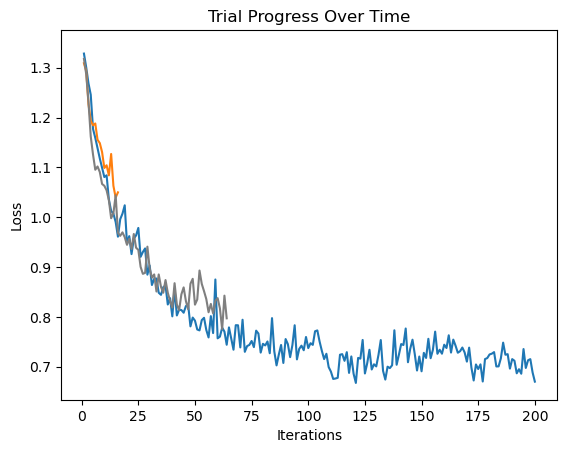

In [13]:
dfs = analysis.trial_dataframes
import matplotlib.pyplot as plt

for d in dfs.values():
    # TODO: Plot the results
    plt.plot(d['training_iteration'], d['loss'], label=d['config/weight_decay'][0])

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Trial Progress Over Time')
plt.show()

In [11]:
# run with best hyperparameters
ult_cnn = UltimateConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ult_cnn.parameters(), lr = 0.00734, betas=(0.9, 0.99), eps=1e-6, weight_decay=0.0004370)

ult_cnn = ult_cnn.to(device)
train(ult_cnn, train_loader, valid_loader, criterion, optimizer, device=device, epochs=200,patience=40)

test_accuracy = evaluate(ult_cnn, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:11<03:47,  1.20s/it]

Epoch [10/200], Loss: 1.1349, Validation Accuracy: 52.96%


 10%|█         | 20/200 [00:23<03:34,  1.19s/it]

Epoch [20/200], Loss: 1.0746, Validation Accuracy: 51.30%


 15%|█▌        | 30/200 [00:35<03:22,  1.19s/it]

Epoch [30/200], Loss: 0.9756, Validation Accuracy: 62.65%


 20%|██        | 40/200 [00:46<03:18,  1.24s/it]

Epoch [40/200], Loss: 0.9161, Validation Accuracy: 64.54%


 25%|██▌       | 50/200 [00:58<02:59,  1.20s/it]

Epoch [50/200], Loss: 0.9016, Validation Accuracy: 64.30%


 30%|███       | 60/200 [01:10<02:47,  1.19s/it]

Epoch [60/200], Loss: 0.8424, Validation Accuracy: 66.67%


 35%|███▌      | 70/200 [01:22<02:35,  1.19s/it]

Epoch [70/200], Loss: 0.8422, Validation Accuracy: 67.14%


 40%|████      | 80/200 [01:33<02:23,  1.20s/it]

Epoch [80/200], Loss: 0.8537, Validation Accuracy: 67.14%


 45%|████▌     | 90/200 [01:45<02:11,  1.19s/it]

Epoch [90/200], Loss: 0.8197, Validation Accuracy: 67.85%


 50%|█████     | 100/200 [01:57<01:59,  1.20s/it]

Epoch [100/200], Loss: 0.8074, Validation Accuracy: 69.27%


 55%|█████▌    | 110/200 [02:08<01:47,  1.19s/it]

Epoch [110/200], Loss: 0.8270, Validation Accuracy: 68.79%


 60%|██████    | 120/200 [02:20<01:35,  1.19s/it]

Epoch [120/200], Loss: 0.7870, Validation Accuracy: 69.50%


 65%|██████▌   | 130/200 [02:31<01:23,  1.19s/it]

Epoch [130/200], Loss: 0.8020, Validation Accuracy: 68.79%


 70%|███████   | 140/200 [02:43<01:11,  1.19s/it]

Epoch [140/200], Loss: 0.7722, Validation Accuracy: 74.23%


 75%|███████▌  | 150/200 [02:55<00:58,  1.17s/it]

Epoch [150/200], Loss: 0.8024, Validation Accuracy: 69.50%


 80%|████████  | 160/200 [03:06<00:46,  1.17s/it]

Epoch [160/200], Loss: 0.7967, Validation Accuracy: 70.69%


 85%|████████▌ | 170/200 [03:18<00:35,  1.19s/it]

Epoch [170/200], Loss: 0.7948, Validation Accuracy: 66.43%


 90%|█████████ | 180/200 [03:29<00:23,  1.19s/it]

Epoch [180/200], Loss: 0.8270, Validation Accuracy: 69.03%


 94%|█████████▍| 189/200 [03:40<00:12,  1.17s/it]


KeyboardInterrupt: 

In [8]:
vit = ViT(patch_size=(22, 1), num_classes=4, dim=64, num_head=8, num_layers = 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vit.parameters(), lr=0.01, momentum=0.9)

vit = vit.to(device)
train(vit, train_loader, valid_loader, criterion, optimizer, device=device, epochs=200)

test_accuracy = evaluate(vit, test_loader, device=device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

/home/banyh2000/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/200 [00:02<?, ?it/s]


KeyboardInterrupt: 

torch.Size([2, 64])
